# Advanced Lane Finding

In [1]:
# Import all required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

In [3]:
def find_corners(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    return ret, corners

In [4]:
def calibrate_camera(calibration_images_path, filename_prefix='calibration'):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    
    images = glob.glob('{}/{}*.jpg'.format(calibration_images_path, filename_prefix))
    
    # Prepare object points
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinates
    
    
    for fname in images:
        # Read the image
        img = mpimg.imread(fname)
        
        ret, corners = find_corners(img)    

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            # img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # plt.imshow(img)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [5]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = calibrate_camera('camera_cal')

In [6]:
def undistort_image(img, mtx, dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

## `color_and_gradient_threshold`
* Apply color and gradient thresholding to detect lines in an image

In [7]:
# Color and gradient thresholding
def color_and_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

## `perspective_warp`
* Warp an image's perspective to a bird's eye view

In [8]:
def perspective_warp(img):
    # Define image size
    img_size = (img.shape[1], img.shape[0])
        
    x_offset_bottom_left = 230
    x_offset_bottom_right = 230
    y_offset_bottom = 0
        
    x_offset_top_left = 580
    x_offset_top_right = 580
    y_offset_top = 450
    
    # Debugging purposes
#     print(img_size)
#     plt.imshow(img)
#     plt.plot(x_offset_bottom_left, img_size[1]- y_offset_bottom, '.')
#     plt.plot(img_size[0] - x_offset_bottom_right, img_size[1]- y_offset_bottom, '.')
#     plt.plot(img_size[0] - x_offset_top_right, y_offset_top, '.')
#     plt.plot(x_offset_top_left, y_offset_top, '.')
    
    # Four source coordinates
    src = np.float32([
        [x_offset_bottom_left, img_size[1] - y_offset_bottom],
        [img_size[0] - x_offset_bottom_right, img_size[1] - y_offset_bottom],
        [img_size[0] - x_offset_top_right, y_offset_top],
        [x_offset_top_left, y_offset_top]
    ])
    
    dst = np.float32([
        [350, 720],
        [940, 720],
        [1100, 0],
        [230, 0]
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M,img_size, flags=cv2.INTER_LINEAR)

    # Debugging purpose
#     plt.imshow(warped)
    return warped, M, Minv

## `fit_polynomial`
* Given an array of pixels, find a best fit polynomial line

In [9]:
def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

## `Line` class
* This class is used hold all the relevant data for each of the lines

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## `find_lane_pixels`
* Finds lane pixels in a binary image of a road, using a histograms and moving window algorithm

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

## `find_lane_pixels_prior`
* Find lane pixels in a road image using a previously fit line in a similar image.

In [12]:
def find_lane_pixels_prior(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###    
    left_fitx_1 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin
    left_fitx_2 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin
    right_fitx_1 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin
    right_fitx_2 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin
    
    left_lane_inds = ((nonzerox > left_fitx_1) & (nonzerox < left_fitx_2))
    right_lane_inds = ((nonzerox > right_fitx_1) & (nonzerox < right_fitx_2))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

## `draw_lane_lines`
* Draw the left and right lane lines in red and blue colors in a binary image.

In [13]:
def draw_lane_lines(binary_warped, left_line=None, right_line=None):
    # Find our lane pixels first
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    if left_line is not None and right_line is not None and left_line.current_fit is not None and right_line.current_fit is not None:
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit
        leftx, lefty, rightx, righty = find_lane_pixels_prior(binary_warped, left_fit, right_fit)    
    else:
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit

## `measure_curvature_pixels`
* Measure the radius of curvature of the lane lines in meters
* This function converts from pixel to real world space

In [14]:
def measure_curvature_pixels(ploty, left_fitx, right_fitx, img_width):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_index = np.where(ploty==y_eval)

    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    xm_per_pix = 3.7/(np.absolute(left_fitx[y_index] - right_fitx[y_index])) # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    # Utilize `ym_per_pix` & `xm_per_pix` here
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
       
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    print("left line curvature:", left_curverad)
    print("right line curvature:", right_curverad)
    
    lane_center = (left_fitx[y_index] + right_fitx[y_index]) / 2
    image_center = img_width / 2
    distance_from_center = np.absolute(lane_center - image_center) * xm_per_pix
    print("distance from center", distance_from_center)
    return left_curverad, right_curverad, distance_from_center
    

## `unwarp_lane_lines_to_frame`
* This function draws the lane detection map from a warped binary image onto an unwarped orignal image

In [15]:
def unwarp_lane_lines_to_frame(warped, undist, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # print(type(np.int_([pts])))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## `generate_output_image`
This function generates images for each step of the lane detection pipeline
It generates an image for the following steps:

1. Undistortion
2. Binary image from Color and Gradient Thresholding
3. Prespective Transform of the binary image
4. Perspective Transform of the original color image
5. Left and Right line pixels detections
6. Lane detection on original image

In [16]:
def generate_output_image(img, fname, output_dir):    
    undistorted = undistort_image(img, mtx, dist)
    # plt.imshow(undistorted)
    cv2.imwrite(output_dir + '/' + fname + '_undistorted.jpg', cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR) )

    binary = color_and_gradient_threshold(undistorted)
    cv2.imwrite(output_dir + '/' + fname + '_binary.jpg', binary.astype('uint8') * 255 )
    plt.imshow(binary, cmap='gray')

    warped, M, Minv = perspective_warp(binary)
    cv2.imwrite(output_dir + '/' + fname + '_linepixels.jpg', warped.astype('uint8') * 255)

    warped_2, _M, _Minv = perspective_warp(img)
    cv2.imwrite(output_dir + '/' + fname + '_warped.jpg', cv2.cvtColor(warped_2, cv2.COLOR_RGB2BGR))
    plt.imshow(warped_2)

    lane_img, ploty, left_fitx, right_fitx, _, _ = draw_lane_lines(warped)
    cv2.imwrite(output_dir + '/' + fname + '_linepixels_fit_overplotted.jpg', cv2.cvtColor(lane_img, cv2.COLOR_RGB2BGR) )

    plt.imshow(lane_img)

    out_img = unwarp_lane_lines_to_frame(warped, undistorted, ploty, left_fitx, right_fitx, Minv )
    cv2.imwrite(output_dir + '/' + fname + '.jpg', cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
    plt.imshow(out_img)


* Instantiate the `Line` objects

In [17]:
left_line = Line()
right_line = Line()

## `process_image`
* This function is used to execute the lane detection pipeline on frames of a video.

In [18]:
def process_image(img):    
    undistorted = undistort_image(img, mtx, dist)
    binary = color_and_gradient_threshold(undistorted)
    warped, M, Minv = perspective_warp(binary)
    lane_img, ploty, left_fitx, right_fitx, left_fit, right_fit = draw_lane_lines(warped, left_line=left_line, right_line=right_line)
    
    left_curverad, right_curverad, distance_from_center = measure_curvature_pixels(ploty, left_fitx, right_fitx, img.shape[1])
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    out_img = unwarp_lane_lines_to_frame(warped, undistorted, ploty, left_fitx, right_fitx, Minv )
    return out_img

## Detect lanes on `test_images`
Here we detect lanes in the test images and write them to `output_images` directory.

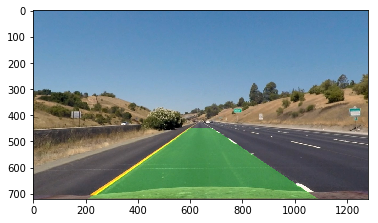

In [19]:
for file in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' + file)
    fname = file.split('.')[0]
    generate_output_image(image, fname, 'output_images')

## Run the pipeline on the video
* This section runs the pipeline on `project_video.mp4` and performs lane detection in each frame.
* The output video is in `output_videos` directory.

In [20]:
video = 'project_video.mp4'
output_video_dir = 'output_videos'
output_video = output_video_dir + '/' + video

clip1 = VideoFileClip(video)
# clip1 = VideoFileClip(video).subclip(0,1)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)


left line curvature: 396.126515850795
right line curvature: 674.3183376036791
distance from center [0.45961687]
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 1/1261 [00:00<02:26,  8.60it/s]

left line curvature: 404.1304135129078
right line curvature: 674.805876832466
distance from center [0.46100554]


  0%|          | 2/1261 [00:00<02:41,  7.79it/s]

left line curvature: 367.24836464993814
right line curvature: 587.786449240304
distance from center [0.44873301]


  0%|          | 3/1261 [00:00<02:40,  7.82it/s]

left line curvature: 369.4979601256536
right line curvature: 603.8101859146251
distance from center [0.45150935]


  0%|          | 4/1261 [00:00<02:39,  7.90it/s]

left line curvature: 364.0594775511089
right line curvature: 540.7457994972438
distance from center [0.44869273]


  0%|          | 5/1261 [00:00<02:37,  7.97it/s]

left line curvature: 380.14090886154736
right line curvature: 416.95895667930637
distance from center [0.45156498]


  0%|          | 6/1261 [00:00<02:37,  7.95it/s]

left line curvature: 397.96732925541806
right line curvature: 361.22030218913426
distance from center [0.45645338]


  1%|          | 7/1261 [00:00<02:37,  7.99it/s]

left line curvature: 405.44915661563465
right line curvature: 354.61372879198234
distance from center [0.45796073]


  1%|          | 8/1261 [00:01<02:41,  7.76it/s]

left line curvature: 410.70783116648903
right line curvature: 449.15639925701686
distance from center [0.4823674]


  1%|          | 9/1261 [00:01<02:40,  7.79it/s]

left line curvature: 440.53815197347683
right line curvature: 567.3776691571123
distance from center [0.49259104]


  1%|          | 10/1261 [00:01<02:40,  7.79it/s]

left line curvature: 431.7545860572265
right line curvature: 625.8682752700302
distance from center [0.49712759]


  1%|          | 11/1261 [00:01<02:39,  7.84it/s]

left line curvature: 454.3220798200933
right line curvature: 845.3659655267256
distance from center [0.50707177]


  1%|          | 12/1261 [00:01<02:39,  7.85it/s]

left line curvature: 524.3711778191307
right line curvature: 798.1368406206966
distance from center [0.50074341]


  1%|          | 13/1261 [00:01<02:38,  7.87it/s]

left line curvature: 544.2676998552508
right line curvature: 996.3990417470106
distance from center [0.50650099]


  1%|          | 14/1261 [00:01<02:37,  7.90it/s]

left line curvature: 491.7700430891759
right line curvature: 532.4869496650774
distance from center [0.47508165]


  1%|          | 15/1261 [00:01<02:36,  7.95it/s]

left line curvature: 475.3464378220639
right line curvature: 529.7092721403012
distance from center [0.4714855]


  1%|▏         | 16/1261 [00:02<02:36,  7.95it/s]

left line curvature: 450.0582191260192
right line curvature: 331.30942951064134
distance from center [0.43945436]


  1%|▏         | 17/1261 [00:02<02:36,  7.93it/s]

left line curvature: 431.6387182224086
right line curvature: 292.3425345614333
distance from center [0.42847085]


  1%|▏         | 18/1261 [00:02<02:36,  7.95it/s]

left line curvature: 500.12005083903193
right line curvature: 332.31554959417497
distance from center [0.44217529]


  2%|▏         | 19/1261 [00:02<02:35,  7.97it/s]

left line curvature: 452.8310436426907
right line curvature: 326.06147698285554
distance from center [0.42250004]


  2%|▏         | 20/1261 [00:02<02:37,  7.89it/s]

left line curvature: 453.22519974334614
right line curvature: 320.5047927568127
distance from center [0.40776377]


  2%|▏         | 21/1261 [00:02<02:36,  7.92it/s]

left line curvature: 490.422843667576
right line curvature: 357.3953754075623
distance from center [0.41143834]


  2%|▏         | 22/1261 [00:02<02:36,  7.94it/s]

left line curvature: 517.5284448977253
right line curvature: 339.28632311987417
distance from center [0.3983249]


  2%|▏         | 23/1261 [00:02<02:35,  7.94it/s]

left line curvature: 540.0918170547682
right line curvature: 387.79753290899555
distance from center [0.40188501]


  2%|▏         | 24/1261 [00:03<02:37,  7.87it/s]

left line curvature: 477.9772797581335
right line curvature: 459.2651947974183
distance from center [0.40553816]


  2%|▏         | 25/1261 [00:03<02:36,  7.89it/s]

left line curvature: 454.8121689518905
right line curvature: 697.5850101203725
distance from center [0.41782202]


  2%|▏         | 26/1261 [00:03<02:36,  7.91it/s]

left line curvature: 486.70478698663163
right line curvature: 862.3624854762832
distance from center [0.42140986]


  2%|▏         | 27/1261 [00:03<02:35,  7.92it/s]

left line curvature: 429.807065353782
right line curvature: 681.2723413146747
distance from center [0.39890145]


  2%|▏         | 28/1261 [00:03<02:35,  7.93it/s]

left line curvature: 457.78027366496025
right line curvature: 643.6844453193085
distance from center [0.39221598]


  2%|▏         | 29/1261 [00:03<02:35,  7.95it/s]

left line curvature: 426.221723171758
right line curvature: 497.22766013509704
distance from center [0.3800634]


  2%|▏         | 30/1261 [00:03<02:34,  7.97it/s]

left line curvature: 396.61877877591826
right line curvature: 535.9962648933533
distance from center [0.37997909]


  2%|▏         | 31/1261 [00:03<02:33,  7.99it/s]

left line curvature: 358.3426032425436
right line curvature: 297.1430613516064
distance from center [0.35342158]


  3%|▎         | 32/1261 [00:03<02:33,  8.00it/s]

left line curvature: 337.1193884985594
right line curvature: 292.4501027715524
distance from center [0.35392304]


  3%|▎         | 33/1261 [00:04<02:33,  8.02it/s]

left line curvature: 307.42961151984497
right line curvature: 271.58924660782765
distance from center [0.32418142]


  3%|▎         | 34/1261 [00:04<02:32,  8.04it/s]

left line curvature: 322.57795041808225
right line curvature: 363.62014312890386
distance from center [0.37828098]


  3%|▎         | 35/1261 [00:04<02:32,  8.05it/s]

left line curvature: 311.4392807017421
right line curvature: 447.71865193933775
distance from center [0.39683206]


  3%|▎         | 36/1261 [00:04<02:32,  8.05it/s]

left line curvature: 296.59058083323333
right line curvature: 484.46508653998166
distance from center [0.40644322]


  3%|▎         | 37/1261 [00:04<02:31,  8.06it/s]

left line curvature: 280.65561058084273
right line curvature: 368.1990497455002
distance from center [0.38130218]


  3%|▎         | 38/1261 [00:04<02:31,  8.07it/s]

left line curvature: 277.6461311346595
right line curvature: 325.4368035818603
distance from center [0.38006163]


  3%|▎         | 39/1261 [00:04<02:31,  8.08it/s]

left line curvature: 278.4306232775793
right line curvature: 285.65536099782105
distance from center [0.37602714]


  3%|▎         | 40/1261 [00:04<02:30,  8.09it/s]

left line curvature: 281.5940943073592
right line curvature: 253.5109680910564
distance from center [0.37313852]


  3%|▎         | 41/1261 [00:05<02:30,  8.09it/s]

left line curvature: 297.21809679608185
right line curvature: 250.95312986712972
distance from center [0.38121903]


  3%|▎         | 42/1261 [00:05<02:30,  8.09it/s]

left line curvature: 302.22489796484774
right line curvature: 265.19037723464737
distance from center [0.39386761]


  3%|▎         | 43/1261 [00:05<02:30,  8.07it/s]

left line curvature: 321.49997124973817
right line curvature: 270.32839976999384
distance from center [0.40684442]


  3%|▎         | 44/1261 [00:05<02:30,  8.06it/s]

left line curvature: 330.46762299384284
right line curvature: 270.58492979067415
distance from center [0.40523527]


  4%|▎         | 45/1261 [00:05<02:31,  8.05it/s]

left line curvature: 343.84901891820874
right line curvature: 277.1094289308098
distance from center [0.40611038]


  4%|▎         | 46/1261 [00:05<02:30,  8.06it/s]

left line curvature: 363.47358878428054
right line curvature: 285.94872056776876
distance from center [0.40633441]


  4%|▎         | 47/1261 [00:05<02:30,  8.06it/s]

left line curvature: 378.10130756326384
right line curvature: 367.89269647747034
distance from center [0.43064654]


  4%|▍         | 48/1261 [00:05<02:30,  8.05it/s]

left line curvature: 383.3283426880893
right line curvature: 456.45771795258645
distance from center [0.45168856]


  4%|▍         | 49/1261 [00:06<02:30,  8.03it/s]

left line curvature: 422.85200235942375
right line curvature: 464.03008739331995
distance from center [0.45134706]


  4%|▍         | 50/1261 [00:06<02:31,  8.02it/s]

left line curvature: 408.6090198150071
right line curvature: 429.51863854299376
distance from center [0.44368226]


  4%|▍         | 51/1261 [00:06<02:31,  8.01it/s]

left line curvature: 437.27152329426184
right line curvature: 459.89612536252764
distance from center [0.44605482]


  4%|▍         | 52/1261 [00:06<02:31,  7.99it/s]

left line curvature: 424.45952032137586
right line curvature: 435.60114090859776
distance from center [0.44056156]


  4%|▍         | 53/1261 [00:06<02:31,  7.98it/s]

left line curvature: 416.68977637376133
right line curvature: 387.8663268759487
distance from center [0.42629022]


  4%|▍         | 54/1261 [00:06<02:31,  7.96it/s]

left line curvature: 420.86758152707426
right line curvature: 326.2877101600056
distance from center [0.41164865]


  4%|▍         | 55/1261 [00:06<02:31,  7.95it/s]

left line curvature: 419.7439369234126
right line curvature: 328.5713200441541
distance from center [0.40750651]


  4%|▍         | 56/1261 [00:07<02:31,  7.94it/s]

left line curvature: 464.951812732186
right line curvature: 331.93911169546664
distance from center [0.4081235]


  5%|▍         | 57/1261 [00:07<02:31,  7.93it/s]

left line curvature: 439.39621836918957
right line curvature: 345.9705027150502
distance from center [0.40168646]


  5%|▍         | 58/1261 [00:07<02:31,  7.92it/s]

left line curvature: 448.86249753024475
right line curvature: 398.72096956437287
distance from center [0.40402565]


  5%|▍         | 59/1261 [00:07<02:31,  7.92it/s]

left line curvature: 435.6435532601156
right line curvature: 620.9534863363662
distance from center [0.43352487]


  5%|▍         | 60/1261 [00:07<02:31,  7.91it/s]

left line curvature: 422.6577068166668
right line curvature: 395.27572060219495
distance from center [0.38853376]


  5%|▍         | 61/1261 [00:07<02:31,  7.90it/s]

left line curvature: 446.5615236935732
right line curvature: 316.6426818926927
distance from center [0.36760775]


  5%|▍         | 62/1261 [00:07<02:32,  7.89it/s]

left line curvature: 416.4437749641347
right line curvature: 267.0216654239637
distance from center [0.34925951]


  5%|▍         | 63/1261 [00:07<02:32,  7.88it/s]

left line curvature: 445.3163340587727
right line curvature: 266.96926666405614
distance from center [0.34021033]


  5%|▌         | 64/1261 [00:08<02:32,  7.86it/s]

left line curvature: 428.7902695931389
right line curvature: 267.5462236887547
distance from center [0.33864316]


  5%|▌         | 65/1261 [00:08<02:32,  7.85it/s]

left line curvature: 469.67020270590945
right line curvature: 275.26295033987805
distance from center [0.33508036]


  5%|▌         | 66/1261 [00:08<02:32,  7.85it/s]

left line curvature: 473.7577773952539
right line curvature: 319.9777369863247
distance from center [0.34244216]


  5%|▌         | 67/1261 [00:08<02:32,  7.84it/s]

left line curvature: 478.58626128728014
right line curvature: 358.94844714248023
distance from center [0.3446956]


  5%|▌         | 68/1261 [00:08<02:32,  7.83it/s]

left line curvature: 489.755011229885
right line curvature: 373.007687312093
distance from center [0.3405441]


  5%|▌         | 69/1261 [00:08<02:32,  7.82it/s]

left line curvature: 456.8013708772825
right line curvature: 369.72090393720663
distance from center [0.33085897]


  6%|▌         | 70/1261 [00:08<02:32,  7.81it/s]

left line curvature: 485.82471678932825
right line curvature: 418.37774022263625
distance from center [0.33117252]


  6%|▌         | 71/1261 [00:09<02:32,  7.80it/s]

left line curvature: 501.6721735631207
right line curvature: 396.2023726110027
distance from center [0.32654281]


  6%|▌         | 72/1261 [00:09<02:32,  7.79it/s]

left line curvature: 514.7989904155764
right line curvature: 400.21692848057177
distance from center [0.32030293]


  6%|▌         | 73/1261 [00:09<02:32,  7.78it/s]

left line curvature: 497.84154140228003
right line curvature: 379.14407192884977
distance from center [0.30644945]


  6%|▌         | 74/1261 [00:09<02:32,  7.77it/s]

left line curvature: 515.5793162885335
right line curvature: 372.1481046484847
distance from center [0.30073782]


  6%|▌         | 75/1261 [00:09<02:32,  7.76it/s]

left line curvature: 538.4460443314351
right line curvature: 369.858958045708
distance from center [0.29366384]


  6%|▌         | 76/1261 [00:09<02:32,  7.76it/s]

left line curvature: 528.053132448191
right line curvature: 350.8120394619693
distance from center [0.28917051]


  6%|▌         | 77/1261 [00:09<02:33,  7.73it/s]

left line curvature: 583.3406079880556
right line curvature: 416.67530196180365
distance from center [0.29543118]


  6%|▌         | 78/1261 [00:10<02:33,  7.72it/s]

left line curvature: 569.6977925505512
right line curvature: 448.2322833791219
distance from center [0.29059473]


  6%|▋         | 79/1261 [00:10<02:33,  7.71it/s]

left line curvature: 610.925223682953
right line curvature: 403.2546929171382
distance from center [0.28051965]


  6%|▋         | 80/1261 [00:10<02:33,  7.70it/s]

left line curvature: 620.386230182756
right line curvature: 349.2502255304238
distance from center [0.2637144]


  6%|▋         | 81/1261 [00:10<02:33,  7.70it/s]

left line curvature: 571.4965532824036
right line curvature: 314.7432382350288
distance from center [0.24941291]


  7%|▋         | 82/1261 [00:10<02:33,  7.69it/s]

left line curvature: 551.5115460697931
right line curvature: 329.2526895108105
distance from center [0.23772894]


  7%|▋         | 83/1261 [00:10<02:33,  7.68it/s]

left line curvature: 524.8858856205509
right line curvature: 328.59304188375836
distance from center [0.22524365]


  7%|▋         | 84/1261 [00:10<02:33,  7.68it/s]

left line curvature: 529.8676495360422
right line curvature: 320.4782300949356
distance from center [0.20497776]


  7%|▋         | 85/1261 [00:11<02:33,  7.66it/s]

left line curvature: 499.47797627402093
right line curvature: 382.37532776904885
distance from center [0.22177492]


  7%|▋         | 86/1261 [00:11<02:33,  7.66it/s]

left line curvature: 469.7549074427166
right line curvature: 448.8869553110319
distance from center [0.23404491]


  7%|▋         | 87/1261 [00:11<02:33,  7.65it/s]

left line curvature: 419.2365625821038
right line curvature: 494.89557680052036
distance from center [0.24177449]


  7%|▋         | 88/1261 [00:11<02:33,  7.65it/s]

left line curvature: 383.69726590627
right line curvature: 430.0365672857827
distance from center [0.22833529]


  7%|▋         | 89/1261 [00:11<02:33,  7.65it/s]

left line curvature: 370.9756987717766
right line curvature: 358.25306682918625
distance from center [0.21915205]


  7%|▋         | 90/1261 [00:11<02:33,  7.64it/s]

left line curvature: 344.0005356500746
right line curvature: 285.1583835008685
distance from center [0.2136287]


  7%|▋         | 91/1261 [00:11<02:33,  7.64it/s]

left line curvature: 352.5177851788362
right line curvature: 315.6279045920865
distance from center [0.21924353]


  7%|▋         | 92/1261 [00:12<02:33,  7.63it/s]

left line curvature: 362.44066830274346
right line curvature: 316.72081293622415
distance from center [0.22645082]


  7%|▋         | 93/1261 [00:12<02:33,  7.62it/s]

left line curvature: 372.28210211941047
right line curvature: 335.0429359690441
distance from center [0.24192117]


  7%|▋         | 94/1261 [00:12<02:33,  7.61it/s]

left line curvature: 361.5436290362175
right line curvature: 368.6546427527553
distance from center [0.24936642]


  8%|▊         | 95/1261 [00:12<02:33,  7.61it/s]

left line curvature: 385.9645953831089
right line curvature: 371.83393864745267
distance from center [0.24916268]


  8%|▊         | 96/1261 [00:12<02:33,  7.60it/s]

left line curvature: 361.58638472536063
right line curvature: 386.87775823299745
distance from center [0.24666739]


  8%|▊         | 97/1261 [00:12<02:33,  7.59it/s]

left line curvature: 349.1309228662269
right line curvature: 410.1113386630983
distance from center [0.25070185]


  8%|▊         | 98/1261 [00:12<02:33,  7.58it/s]

left line curvature: 372.37300512120737
right line curvature: 458.54483201543877
distance from center [0.26161881]


  8%|▊         | 99/1261 [00:13<02:33,  7.58it/s]

left line curvature: 353.56024441757717
right line curvature: 336.9288824818819
distance from center [0.23778048]


  8%|▊         | 100/1261 [00:13<02:33,  7.57it/s]

left line curvature: 356.48634787745374
right line curvature: 388.7243349019137
distance from center [0.24834705]


  8%|▊         | 101/1261 [00:13<02:33,  7.56it/s]

left line curvature: 354.3233159547697
right line curvature: 355.86494908073877
distance from center [0.25018585]


  8%|▊         | 102/1261 [00:13<02:33,  7.56it/s]

left line curvature: 342.6411067108504
right line curvature: 289.8721075231539
distance from center [0.23479369]


  8%|▊         | 103/1261 [00:13<02:33,  7.55it/s]

left line curvature: 337.0576344156527
right line curvature: 278.2236324207208
distance from center [0.23765992]


  8%|▊         | 104/1261 [00:13<02:33,  7.54it/s]

left line curvature: 342.84780582736624
right line curvature: 264.65483119448123
distance from center [0.24263107]


  8%|▊         | 105/1261 [00:13<02:33,  7.54it/s]

left line curvature: 365.761210808007
right line curvature: 274.75640311503804
distance from center [0.25055121]


  8%|▊         | 106/1261 [00:14<02:33,  7.53it/s]

left line curvature: 361.77540637576163
right line curvature: 276.34396079960686
distance from center [0.25458165]


  8%|▊         | 107/1261 [00:14<02:33,  7.52it/s]

left line curvature: 365.93641193054316
right line curvature: 279.5613838294675
distance from center [0.25502738]


  9%|▊         | 108/1261 [00:14<02:33,  7.51it/s]

left line curvature: 330.56997398641585
right line curvature: 250.0648097790351
distance from center [0.24452224]


  9%|▊         | 109/1261 [00:14<02:33,  7.50it/s]

left line curvature: 329.97912114117685
right line curvature: 269.2449707564503
distance from center [0.25267309]


  9%|▊         | 110/1261 [00:14<02:33,  7.50it/s]

left line curvature: 347.21828585115526
right line curvature: 324.5142285524273
distance from center [0.28741936]


  9%|▉         | 111/1261 [00:14<02:33,  7.49it/s]

left line curvature: 345.397656071449
right line curvature: 399.4736399019401
distance from center [0.31304699]


  9%|▉         | 112/1261 [00:14<02:33,  7.48it/s]

left line curvature: 372.6561198702282
right line curvature: 396.63627768251615
distance from center [0.31381334]


  9%|▉         | 113/1261 [00:15<02:33,  7.48it/s]

left line curvature: 342.9249588832642
right line curvature: 314.6413062549903
distance from center [0.30192138]


  9%|▉         | 114/1261 [00:15<02:33,  7.48it/s]

left line curvature: 338.44624030680603
right line curvature: 341.57760882016555
distance from center [0.31507661]


  9%|▉         | 115/1261 [00:15<02:33,  7.47it/s]

left line curvature: 317.5389020748536
right line curvature: 301.8741619182601
distance from center [0.31108132]


  9%|▉         | 116/1261 [00:15<02:33,  7.47it/s]

left line curvature: 316.3084686231496
right line curvature: 247.14332730312998
distance from center [0.30267467]


  9%|▉         | 117/1261 [00:15<02:33,  7.45it/s]

left line curvature: 329.6394413195788
right line curvature: 253.4737871405265
distance from center [0.31353793]


  9%|▉         | 118/1261 [00:15<02:33,  7.45it/s]

left line curvature: 319.90599028336544
right line curvature: 249.64057082664996
distance from center [0.31551775]


  9%|▉         | 119/1261 [00:15<02:33,  7.44it/s]

left line curvature: 322.402533706991
right line curvature: 272.3656119607649
distance from center [0.33339282]


 10%|▉         | 120/1261 [00:16<02:33,  7.44it/s]

left line curvature: 303.2910597353038
right line curvature: 316.2572976956107
distance from center [0.35188385]


 10%|▉         | 121/1261 [00:16<02:33,  7.43it/s]

left line curvature: 321.3070512056857
right line curvature: 385.2567245300977
distance from center [0.38204794]


 10%|▉         | 122/1261 [00:16<02:33,  7.43it/s]

left line curvature: 318.5876296544605
right line curvature: 370.81296523617175
distance from center [0.38669276]


 10%|▉         | 123/1261 [00:16<02:33,  7.42it/s]

left line curvature: 307.7425799072816
right line curvature: 333.7315127432847
distance from center [0.37715155]


 10%|▉         | 124/1261 [00:16<02:33,  7.42it/s]

left line curvature: 302.3108752314515
right line curvature: 273.34197883138967
distance from center [0.35910326]


 10%|▉         | 125/1261 [00:16<02:33,  7.41it/s]

left line curvature: 302.18328498986705
right line curvature: 248.4013466118373
distance from center [0.35827638]


 10%|▉         | 126/1261 [00:17<02:33,  7.41it/s]

left line curvature: 330.68336852003506
right line curvature: 320.20025337499874
distance from center [0.38617214]


 10%|█         | 127/1261 [00:17<02:33,  7.40it/s]

left line curvature: 329.45438196709415
right line curvature: 265.29483756992255
distance from center [0.37893408]


 10%|█         | 128/1261 [00:17<02:33,  7.40it/s]

left line curvature: 330.46346555405194
right line curvature: 277.56466719705344
distance from center [0.38205856]


 10%|█         | 129/1261 [00:17<02:33,  7.39it/s]

left line curvature: 330.2268126212308
right line curvature: 304.620676355561
distance from center [0.40395112]


 10%|█         | 130/1261 [00:17<02:33,  7.38it/s]

left line curvature: 348.9903786343068
right line curvature: 318.19858358632956
distance from center [0.4044208]


 10%|█         | 131/1261 [00:17<02:33,  7.38it/s]

left line curvature: 353.5353129289372
right line curvature: 340.903866913459
distance from center [0.41599725]


 10%|█         | 132/1261 [00:17<02:33,  7.38it/s]

left line curvature: 351.540392926919
right line curvature: 361.6474002222687
distance from center [0.42404287]


 11%|█         | 133/1261 [00:18<02:33,  7.37it/s]

left line curvature: 363.4780011190981
right line curvature: 409.39268511675937
distance from center [0.43660033]


 11%|█         | 134/1261 [00:18<02:33,  7.36it/s]

left line curvature: 375.91605035276075
right line curvature: 376.9489633157569
distance from center [0.44182407]


 11%|█         | 135/1261 [00:18<02:33,  7.36it/s]

left line curvature: 396.85097698417525
right line curvature: 423.1821191082888
distance from center [0.45787988]


 11%|█         | 136/1261 [00:18<02:32,  7.36it/s]

left line curvature: 409.0524364578696
right line curvature: 413.1163142731533
distance from center [0.45449031]


 11%|█         | 137/1261 [00:18<02:32,  7.35it/s]

left line curvature: 409.9005028554373
right line curvature: 478.6568272613473
distance from center [0.45746986]


 11%|█         | 138/1261 [00:18<02:32,  7.35it/s]

left line curvature: 434.2914606517693
right line curvature: 458.55706334957534
distance from center [0.44840448]


 11%|█         | 140/1261 [00:19<02:33,  7.30it/s]

left line curvature: 438.1645999230821
right line curvature: 480.0221693999458
distance from center [0.44592511]
left line curvature: 484.57200929272864
right line curvature: 557.1876446235103
distance from center [0.44720101]


 11%|█▏        | 142/1261 [00:19<02:33,  7.31it/s]

left line curvature: 510.84277881793696
right line curvature: 417.19664372273627
distance from center [0.43689205]
left line curvature: 479.64269973079126
right line curvature: 390.4960128297836
distance from center [0.4232158]


 11%|█▏        | 144/1261 [00:19<02:32,  7.31it/s]

left line curvature: 454.4037554576531
right line curvature: 336.24078060058025
distance from center [0.41718821]
left line curvature: 455.94495102576377
right line curvature: 372.50533002053174
distance from center [0.41515926]


 12%|█▏        | 146/1261 [00:19<02:32,  7.31it/s]

left line curvature: 488.1609997753829
right line curvature: 389.1957388895202
distance from center [0.41536289]
left line curvature: 437.1818717444084
right line curvature: 485.6640545910383
distance from center [0.42301265]


 12%|█▏        | 148/1261 [00:20<02:32,  7.31it/s]

left line curvature: 477.20449086470614
right line curvature: 486.59073545441663
distance from center [0.42681458]
left line curvature: 424.64951559962265
right line curvature: 378.5241044917794
distance from center [0.41319182]


 12%|█▏        | 150/1261 [00:20<02:31,  7.32it/s]

left line curvature: 410.7614055200702
right line curvature: 319.18709237915067
distance from center [0.39560887]
left line curvature: 419.7039164056878
right line curvature: 360.9069798327699
distance from center [0.40168203]


 12%|█▏        | 152/1261 [00:20<02:31,  7.32it/s]

left line curvature: 437.87762009175265
right line curvature: 413.2468299608586
distance from center [0.40923917]
left line curvature: 444.14664118642634
right line curvature: 355.2050928455558
distance from center [0.38961505]


 12%|█▏        | 154/1261 [00:21<02:31,  7.32it/s]

left line curvature: 403.24595228792987
right line curvature: 291.5968010627068
distance from center [0.37226699]
left line curvature: 430.8004615557537
right line curvature: 324.24825677436263
distance from center [0.38222995]


 12%|█▏        | 156/1261 [00:21<02:30,  7.32it/s]

left line curvature: 425.0117345276367
right line curvature: 331.66477671913606
distance from center [0.38009602]
left line curvature: 415.11332187361853
right line curvature: 331.0371943810647
distance from center [0.37570043]


 13%|█▎        | 158/1261 [00:21<02:30,  7.32it/s]

left line curvature: 416.3870549645466
right line curvature: 352.559230705107
distance from center [0.37679175]
left line curvature: 384.13856270501486
right line curvature: 413.8578737368486
distance from center [0.37792903]


 13%|█▎        | 160/1261 [00:21<02:30,  7.33it/s]

left line curvature: 388.8368271188727
right line curvature: 406.6579714528693
distance from center [0.37166163]
left line curvature: 361.6401837264552
right line curvature: 329.53421409704646
distance from center [0.34088285]


 13%|█▎        | 162/1261 [00:22<02:30,  7.33it/s]

left line curvature: 390.17111088388776
right line curvature: 416.85023304276694
distance from center [0.36515659]
left line curvature: 378.3298296428232
right line curvature: 374.8428159284343
distance from center [0.3498427]


 13%|█▎        | 164/1261 [00:22<02:29,  7.33it/s]

left line curvature: 390.1809311549143
right line curvature: 406.7375513570266
distance from center [0.35248092]
left line curvature: 404.98123324946897
right line curvature: 310.0627886211374
distance from center [0.33837806]


 13%|█▎        | 166/1261 [00:22<02:29,  7.33it/s]

left line curvature: 355.55714388145435
right line curvature: 215.99569503178353
distance from center [0.30616346]
left line curvature: 367.4135042070452
right line curvature: 227.3956076826511
distance from center [0.31153871]


 13%|█▎        | 168/1261 [00:22<02:29,  7.33it/s]

left line curvature: 348.36777790519784
right line curvature: 242.72785508124971
distance from center [0.32462685]
left line curvature: 370.92005476428915
right line curvature: 249.25153657747953
distance from center [0.32457674]


 13%|█▎        | 170/1261 [00:23<02:28,  7.33it/s]

left line curvature: 379.7857567027155
right line curvature: 247.00870519385123
distance from center [0.32059879]
left line curvature: 410.4472637922346
right line curvature: 243.93719956553113
distance from center [0.30548505]


 14%|█▎        | 172/1261 [00:23<02:28,  7.33it/s]

left line curvature: 401.4323093893807
right line curvature: 235.95308516626898
distance from center [0.28345454]
left line curvature: 375.37468676845293
right line curvature: 231.95762667891924
distance from center [0.27256289]


 14%|█▍        | 174/1261 [00:23<02:28,  7.34it/s]

left line curvature: 363.6266236834871
right line curvature: 229.00614666587975
distance from center [0.27493387]
left line curvature: 330.9377704501584
right line curvature: 210.53554934812192
distance from center [0.26206078]


 14%|█▍        | 176/1261 [00:23<02:27,  7.34it/s]

left line curvature: 306.84359947426907
right line curvature: 186.77122627409616
distance from center [0.24362883]
left line curvature: 295.34907519297843
right line curvature: 182.71610241077198
distance from center [0.24195337]


 14%|█▍        | 178/1261 [00:24<02:27,  7.34it/s]

left line curvature: 327.47410268807056
right line curvature: 203.41835404281812
distance from center [0.25395389]
left line curvature: 324.05907905231055
right line curvature: 210.39325286082652
distance from center [0.26279409]


 14%|█▍        | 180/1261 [00:24<02:27,  7.34it/s]

left line curvature: 331.12276354936057
right line curvature: 220.1997214547627
distance from center [0.27570365]
left line curvature: 350.0298306689385
right line curvature: 231.2200106702673
distance from center [0.28726839]


 14%|█▍        | 182/1261 [00:24<02:26,  7.34it/s]

left line curvature: 315.1243190938351
right line curvature: 268.689473857384
distance from center [0.2991518]
left line curvature: 327.2386177381351
right line curvature: 281.9932907668794
distance from center [0.3030615]


 15%|█▍        | 184/1261 [00:25<02:26,  7.34it/s]

left line curvature: 310.5519075164734
right line curvature: 323.116556485787
distance from center [0.32397563]
left line curvature: 291.44904021617634
right line curvature: 318.2297539154805
distance from center [0.32390178]


 15%|█▍        | 186/1261 [00:25<02:27,  7.30it/s]

left line curvature: 274.3488577598219
right line curvature: 262.674972335795
distance from center [0.29731392]
left line curvature: 240.22348330799866
right line curvature: 215.02947101207707
distance from center [0.28002292]


 15%|█▍        | 188/1261 [00:25<02:26,  7.30it/s]

left line curvature: 240.95194242929946
right line curvature: 225.28492580693145
distance from center [0.28707604]
left line curvature: 233.40964548140758
right line curvature: 234.51548616174313
distance from center [0.29895285]


 15%|█▌        | 190/1261 [00:26<02:26,  7.30it/s]

left line curvature: 241.85379789702117
right line curvature: 262.8528426889299
distance from center [0.31920781]
left line curvature: 239.9865678899303
right line curvature: 242.61410671479433
distance from center [0.31961284]


 15%|█▌        | 192/1261 [00:26<02:27,  7.27it/s]

left line curvature: 239.06086143627414
right line curvature: 239.1044816789038
distance from center [0.32726271]
left line curvature: 254.48746675339453
right line curvature: 252.01580401091246
distance from center [0.34228587]


 15%|█▌        | 194/1261 [00:26<02:26,  7.27it/s]

left line curvature: 239.70166255954297
right line curvature: 221.03055432984752
distance from center [0.33821862]
left line curvature: 253.20927204987547
right line curvature: 230.17991192169168
distance from center [0.34477638]


 16%|█▌        | 196/1261 [00:26<02:26,  7.27it/s]

left line curvature: 255.55236888171768
right line curvature: 215.08193023213855
distance from center [0.33125776]
left line curvature: 315.3977896806371
right line curvature: 280.1654393638627
distance from center [0.3572463]


 16%|█▌        | 198/1261 [00:27<02:26,  7.27it/s]

left line curvature: 380.2059675062126
right line curvature: 417.52148680979684
distance from center [0.39021593]
left line curvature: 428.46148451477933
right line curvature: 364.5077394005856
distance from center [0.36598078]


 16%|█▌        | 200/1261 [00:27<02:25,  7.27it/s]

left line curvature: 435.04889770367134
right line curvature: 362.46880404612085
distance from center [0.35168177]
left line curvature: 434.6046555152021
right line curvature: 437.8907215887011
distance from center [0.36322394]


 16%|█▌        | 202/1261 [00:27<02:25,  7.27it/s]

left line curvature: 446.99632591512955
right line curvature: 491.24285757054173
distance from center [0.36352734]
left line curvature: 415.60898816711193
right line curvature: 431.08852040956003
distance from center [0.34629124]


 16%|█▌        | 204/1261 [00:28<02:25,  7.28it/s]

left line curvature: 396.06028849479907
right line curvature: 406.2838228637286
distance from center [0.33489505]
left line curvature: 413.3433969547799
right line curvature: 379.5704267082956
distance from center [0.33189126]


 16%|█▋        | 206/1261 [00:28<02:24,  7.28it/s]

left line curvature: 381.1094234859098
right line curvature: 307.48607060075597
distance from center [0.31836325]
left line curvature: 366.1514607545143
right line curvature: 300.34540759961925
distance from center [0.31626223]


 16%|█▋        | 208/1261 [00:28<02:24,  7.28it/s]

left line curvature: 331.42696816379356
right line curvature: 425.8310182846466
distance from center [0.34886816]
left line curvature: 315.99756828927224
right line curvature: 436.84118414462006
distance from center [0.35417515]


 17%|█▋        | 210/1261 [00:28<02:24,  7.28it/s]

left line curvature: 335.04728399939904
right line curvature: 464.4222310266127
distance from center [0.36072829]
left line curvature: 345.25296829385957
right line curvature: 543.8567161148085
distance from center [0.36505565]


 17%|█▋        | 212/1261 [00:29<02:24,  7.28it/s]

left line curvature: 369.4997603984298
right line curvature: 581.3910591164058
distance from center [0.35963253]
left line curvature: 366.9387942068831
right line curvature: 542.4361926556786
distance from center [0.35732544]


 17%|█▋        | 214/1261 [00:29<02:23,  7.28it/s]

left line curvature: 369.44290922582223
right line curvature: 540.8984178586119
distance from center [0.35333765]
left line curvature: 358.6222301947176
right line curvature: 565.5119064593181
distance from center [0.34902506]


 17%|█▋        | 216/1261 [00:29<02:23,  7.28it/s]

left line curvature: 355.44980960043875
right line curvature: 403.0639514093504
distance from center [0.32524931]
left line curvature: 362.52465854249976
right line curvature: 344.6768033823252
distance from center [0.31152348]


 17%|█▋        | 218/1261 [00:29<02:23,  7.28it/s]

left line curvature: 368.64094819345183
right line curvature: 330.51949549655455
distance from center [0.30988793]
left line curvature: 381.25122385126974
right line curvature: 333.18233296699356
distance from center [0.3011527]


 17%|█▋        | 220/1261 [00:30<02:22,  7.28it/s]

left line curvature: 387.42788789433877
right line curvature: 405.327040737314
distance from center [0.31531812]
left line curvature: 403.3668634995457
right line curvature: 358.22857820056845
distance from center [0.29047682]


 18%|█▊        | 222/1261 [00:30<02:22,  7.28it/s]

left line curvature: 405.6288049177061
right line curvature: 399.14164630746245
distance from center [0.30038908]
left line curvature: 430.27178757861935
right line curvature: 502.1110505719448
distance from center [0.31950083]


 18%|█▊        | 224/1261 [00:30<02:22,  7.29it/s]

left line curvature: 461.6007745147899
right line curvature: 501.96286350984525
distance from center [0.31801035]
left line curvature: 402.27118241765334
right line curvature: 393.94276421308774
distance from center [0.29819674]


 18%|█▊        | 226/1261 [00:31<02:22,  7.29it/s]

left line curvature: 441.14978539042517
right line curvature: 401.3639892654189
distance from center [0.29594599]
left line curvature: 428.95185591841306
right line curvature: 282.4824893285781
distance from center [0.26554393]


 18%|█▊        | 228/1261 [00:31<02:21,  7.29it/s]

left line curvature: 456.79846215721847
right line curvature: 267.1358040933061
distance from center [0.25850944]
left line curvature: 443.0292383364246
right line curvature: 270.5273392934288
distance from center [0.24668561]


 18%|█▊        | 230/1261 [00:31<02:21,  7.29it/s]

left line curvature: 456.7127208961654
right line curvature: 279.8817317256557
distance from center [0.24944741]
left line curvature: 488.3184791035579
right line curvature: 269.05586018099893
distance from center [0.23600159]


 18%|█▊        | 232/1261 [00:31<02:21,  7.29it/s]

left line curvature: 458.3942176070067
right line curvature: 276.89947075434213
distance from center [0.22652911]
left line curvature: 472.22943650966096
right line curvature: 271.57011050064045
distance from center [0.20397115]


 19%|█▊        | 234/1261 [00:32<02:20,  7.29it/s]

left line curvature: 462.9484617567671
right line curvature: 280.1703904665684
distance from center [0.19259738]
left line curvature: 447.40562257276395
right line curvature: 316.77249200826384
distance from center [0.20160008]


 19%|█▊        | 236/1261 [00:32<02:20,  7.29it/s]

left line curvature: 445.5684891748343
right line curvature: 315.3378429785904
distance from center [0.19546402]
left line curvature: 396.9102740447138
right line curvature: 242.59734242884596
distance from center [0.16529252]


 19%|█▉        | 238/1261 [00:32<02:20,  7.29it/s]

left line curvature: 394.4806126374888
right line curvature: 234.18344170472864
distance from center [0.15813662]
left line curvature: 374.80622032310305
right line curvature: 219.83935280522869
distance from center [0.15316568]


 19%|█▉        | 240/1261 [00:32<02:20,  7.29it/s]

left line curvature: 367.3367480487512
right line curvature: 238.25080632134896
distance from center [0.16278462]
left line curvature: 364.354969398702
right line curvature: 258.13474399249577
distance from center [0.16810061]


 19%|█▉        | 242/1261 [00:33<02:19,  7.29it/s]

left line curvature: 375.0034655462638
right line curvature: 281.2016033749228
distance from center [0.17415054]
left line curvature: 398.0307135411271
right line curvature: 295.52320184196265
distance from center [0.17292573]


 19%|█▉        | 244/1261 [00:33<02:19,  7.29it/s]

left line curvature: 368.6490084171628
right line curvature: 301.01431737925964
distance from center [0.174296]
left line curvature: 375.44122080153574
right line curvature: 321.72161787575766
distance from center [0.17402879]


 20%|█▉        | 246/1261 [00:33<02:19,  7.29it/s]

left line curvature: 361.38486843227275
right line curvature: 242.07095545177077
distance from center [0.13190985]
left line curvature: 343.45858953902075
right line curvature: 206.61150491857646
distance from center [0.09910213]


 20%|█▉        | 248/1261 [00:33<02:18,  7.29it/s]

left line curvature: 356.3245818364831
right line curvature: 228.59243351421873
distance from center [0.11355848]
left line curvature: 334.1573366696169
right line curvature: 215.69677153995522
distance from center [0.11390956]


 20%|█▉        | 250/1261 [00:34<02:18,  7.29it/s]

left line curvature: 354.59100069318976
right line curvature: 238.34567228456544
distance from center [0.12333057]
left line curvature: 361.8716821134432
right line curvature: 242.06285771125494
distance from center [0.12915847]


 20%|█▉        | 252/1261 [00:34<02:18,  7.30it/s]

left line curvature: 379.0031298819002
right line curvature: 267.93051195852064
distance from center [0.1388429]
left line curvature: 384.77772068263647
right line curvature: 271.3648339922451
distance from center [0.13878931]


 20%|██        | 254/1261 [00:34<02:18,  7.30it/s]

left line curvature: 401.38182597043874
right line curvature: 302.2533565602112
distance from center [0.15085709]
left line curvature: 433.8141786872866
right line curvature: 312.01137367218735
distance from center [0.15389385]


 20%|██        | 256/1261 [00:35<02:17,  7.30it/s]

left line curvature: 406.25008219272473
right line curvature: 301.71467124895116
distance from center [0.1520201]
left line curvature: 411.8428716125548
right line curvature: 321.8058861539327
distance from center [0.14953273]


 20%|██        | 258/1261 [00:35<02:17,  7.29it/s]

left line curvature: 397.54811539121425
right line curvature: 280.57492748691186
distance from center [0.1309722]
left line curvature: 379.62877998314195
right line curvature: 252.6209590656042
distance from center [0.1118339]


 21%|██        | 260/1261 [00:35<02:17,  7.29it/s]

left line curvature: 388.19148119013727
right line curvature: 233.6771531000033
distance from center [0.09938749]
left line curvature: 374.6114866828312
right line curvature: 228.4947219692167
distance from center [0.11088912]


 21%|██        | 262/1261 [00:35<02:17,  7.29it/s]

left line curvature: 409.6126774347314
right line curvature: 255.2294007226699
distance from center [0.12388505]
left line curvature: 405.87636843122976
right line curvature: 264.68243561973884
distance from center [0.14017569]


 21%|██        | 264/1261 [00:36<02:16,  7.29it/s]

left line curvature: 418.3967713956425
right line curvature: 278.0504752877041
distance from center [0.15183874]
left line curvature: 422.3825417126357
right line curvature: 294.32705362734555
distance from center [0.15640486]


 21%|██        | 266/1261 [00:36<02:16,  7.29it/s]

left line curvature: 446.2159163552853
right line curvature: 307.77762376019723
distance from center [0.16556336]
left line curvature: 457.6607519273949
right line curvature: 337.16310721623535
distance from center [0.16802241]


 21%|██▏       | 268/1261 [00:36<02:16,  7.29it/s]

left line curvature: 429.6803105043554
right line curvature: 370.1231973205978
distance from center [0.17728569]
left line curvature: 452.81124960832886
right line curvature: 419.49704112388196
distance from center [0.18575447]


 21%|██▏       | 270/1261 [00:37<02:15,  7.29it/s]

left line curvature: 461.34881153374914
right line curvature: 447.15014860796595
distance from center [0.18991622]
left line curvature: 485.9444345828654
right line curvature: 520.5197304431762
distance from center [0.20584415]


 22%|██▏       | 272/1261 [00:37<02:15,  7.29it/s]

left line curvature: 470.74301392614575
right line curvature: 548.509897863749
distance from center [0.20894055]
left line curvature: 456.3900817526714
right line curvature: 419.77724353514077
distance from center [0.19817349]


 22%|██▏       | 274/1261 [00:37<02:15,  7.29it/s]

left line curvature: 466.696212992477
right line curvature: 331.3518849083292
distance from center [0.17977623]
left line curvature: 482.11226583426225
right line curvature: 364.68528772431813
distance from center [0.20159156]


 22%|██▏       | 276/1261 [00:37<02:15,  7.29it/s]

left line curvature: 482.5212948140564
right line curvature: 377.29053370461696
distance from center [0.20443656]
left line curvature: 543.0736087232051
right line curvature: 390.95152208281814
distance from center [0.21406026]


 22%|██▏       | 278/1261 [00:38<02:14,  7.29it/s]

left line curvature: 564.1078813765937
right line curvature: 399.15701480689114
distance from center [0.21889131]
left line curvature: 587.6917678001969
right line curvature: 413.53818573894193
distance from center [0.21968349]


 22%|██▏       | 280/1261 [00:38<02:14,  7.29it/s]

left line curvature: 602.0955726983697
right line curvature: 471.3597583240661
distance from center [0.23440831]
left line curvature: 618.6330667098795
right line curvature: 505.7951667513472
distance from center [0.23589254]


 22%|██▏       | 282/1261 [00:38<02:14,  7.29it/s]

left line curvature: 662.7936600896205
right line curvature: 519.9360583894185
distance from center [0.24594622]
left line curvature: 595.2873725407079
right line curvature: 437.6632508849395
distance from center [0.2334222]


 23%|██▎       | 284/1261 [00:38<02:13,  7.29it/s]

left line curvature: 630.6461192317779
right line curvature: 523.1243559088718
distance from center [0.24626185]
left line curvature: 633.4533411302498
right line curvature: 435.14322709247705
distance from center [0.24361763]


 23%|██▎       | 286/1261 [00:39<02:13,  7.29it/s]

left line curvature: 669.1350349440179
right line curvature: 490.3220529186051
distance from center [0.25416356]
left line curvature: 720.1488628426529
right line curvature: 477.7229807899225
distance from center [0.25712751]


 23%|██▎       | 288/1261 [00:39<02:13,  7.29it/s]

left line curvature: 746.3875498559321
right line curvature: 421.5580240009073
distance from center [0.25430992]
left line curvature: 791.5981595852192
right line curvature: 438.4682818694968
distance from center [0.26021388]


 23%|██▎       | 290/1261 [00:39<02:13,  7.29it/s]

left line curvature: 784.5910274117465
right line curvature: 423.4786188337965
distance from center [0.26956048]
left line curvature: 797.0542565830286
right line curvature: 470.7034018819506
distance from center [0.2774736]


 23%|██▎       | 292/1261 [00:40<02:12,  7.29it/s]

left line curvature: 823.6926239401898
right line curvature: 570.9140041986093
distance from center [0.29362548]
left line curvature: 739.7077312654732
right line curvature: 668.6505374590074
distance from center [0.29713232]


 23%|██▎       | 294/1261 [00:40<02:12,  7.28it/s]

left line curvature: 838.9881550085157
right line curvature: 725.5202511649024
distance from center [0.3114663]
left line curvature: 796.2931884506932
right line curvature: 619.9134741693358
distance from center [0.30720392]


 23%|██▎       | 296/1261 [00:40<02:12,  7.28it/s]

left line curvature: 786.1813878006844
right line curvature: 702.9794169676736
distance from center [0.31214184]
left line curvature: 824.3922009500131
right line curvature: 597.4285669879985
distance from center [0.30856198]


 24%|██▎       | 298/1261 [00:40<02:12,  7.29it/s]

left line curvature: 809.6240175209242
right line curvature: 684.1951761236448
distance from center [0.30731791]
left line curvature: 994.2326934032027
right line curvature: 641.2668208562977
distance from center [0.31142307]


 24%|██▍       | 300/1261 [00:41<02:11,  7.29it/s]

left line curvature: 1086.4819000301247
right line curvature: 645.6223229122137
distance from center [0.30863159]
left line curvature: 1140.889970447363
right line curvature: 667.8234964627436
distance from center [0.31182745]


 24%|██▍       | 302/1261 [00:41<02:11,  7.29it/s]

left line curvature: 1369.5431260358885
right line curvature: 722.8746931028007
distance from center [0.31677486]
left line curvature: 1428.242818128671
right line curvature: 742.8195890220371
distance from center [0.3142198]


 24%|██▍       | 304/1261 [00:41<02:11,  7.29it/s]

left line curvature: 1685.930065123943
right line curvature: 961.822685544017
distance from center [0.32225302]
left line curvature: 1838.7572206622335
right line curvature: 1396.450983816752
distance from center [0.33013309]


 24%|██▍       | 306/1261 [00:41<02:10,  7.29it/s]

left line curvature: 1922.3850317944816
right line curvature: 3188.2976029397464
distance from center [0.35113107]
left line curvature: 1886.5999042334029
right line curvature: 6087.593776760695
distance from center [0.34856173]


 24%|██▍       | 308/1261 [00:42<02:10,  7.29it/s]

left line curvature: 2540.265196015138
right line curvature: 48450.41511602536
distance from center [0.35663531]
left line curvature: 2379.6429949097214
right line curvature: 2232.751339377761
distance from center [0.3398864]


 25%|██▍       | 310/1261 [00:42<02:10,  7.29it/s]

left line curvature: 3202.11677970393
right line curvature: 1676.630590825249
distance from center [0.33495235]
left line curvature: 3987.3001469337905
right line curvature: 894.4248346749213
distance from center [0.32352329]


 25%|██▍       | 312/1261 [00:42<02:10,  7.29it/s]

left line curvature: 4291.412141234824
right line curvature: 1426.3810147990923
distance from center [0.33517845]
left line curvature: 5854.675766553036
right line curvature: 1663.0781494968933
distance from center [0.335088]


 25%|██▍       | 314/1261 [00:43<02:09,  7.30it/s]

left line curvature: 11405.27064274845
right line curvature: 1157.258851198519
distance from center [0.33287998]
left line curvature: 41336.43491525431
right line curvature: 1418.2365346392119
distance from center [0.33636803]


 25%|██▌       | 316/1261 [00:43<02:09,  7.30it/s]

left line curvature: 43805.49999629626
right line curvature: 1468.072063330771
distance from center [0.33848985]
left line curvature: 19079.126946463028
right line curvature: 1163.5967756151974
distance from center [0.3265844]


 25%|██▌       | 318/1261 [00:43<02:09,  7.30it/s]

left line curvature: 14771.195084571025
right line curvature: 1053.8468946230053
distance from center [0.3188374]
left line curvature: 39545.24942009857
right line curvature: 611.0126341552473
distance from center [0.29309902]


 25%|██▌       | 320/1261 [00:43<02:08,  7.30it/s]

left line curvature: 6107.042709676346
right line curvature: 623.6488249626577
distance from center [0.29740058]
left line curvature: 10330.437215030277
right line curvature: 794.193236699411
distance from center [0.31468285]


 26%|██▌       | 322/1261 [00:44<02:08,  7.30it/s]

left line curvature: 5653.133614959315
right line curvature: 853.7080287625989
distance from center [0.32182544]
left line curvature: 7069.855718368863
right line curvature: 939.9878115850046
distance from center [0.32802239]


 26%|██▌       | 324/1261 [00:44<02:08,  7.30it/s]

left line curvature: 3771.370401600788
right line curvature: 1090.023473777753
distance from center [0.33409044]
left line curvature: 4152.90619206539
right line curvature: 983.4206572213402
distance from center [0.32854307]


 26%|██▌       | 326/1261 [00:44<02:08,  7.30it/s]

left line curvature: 4160.00790751438
right line curvature: 1339.9005574465386
distance from center [0.33608791]
left line curvature: 5047.981401500208
right line curvature: 2222.8970900592167
distance from center [0.33863557]


 26%|██▌       | 328/1261 [00:44<02:07,  7.30it/s]

left line curvature: 4577.893502700194
right line curvature: 1912.0277931290207
distance from center [0.33805906]
left line curvature: 4455.314450033099
right line curvature: 3985.6584389566
distance from center [0.34382995]


 26%|██▌       | 330/1261 [00:45<02:07,  7.30it/s]

left line curvature: 5852.771396993559
right line curvature: 6617.542933163098
distance from center [0.35496609]
left line curvature: 3827.5672943784107
right line curvature: 10677.705272940982
distance from center [0.35786776]


 26%|██▋       | 332/1261 [00:45<02:07,  7.30it/s]

left line curvature: 5528.842328825274
right line curvature: 3227.322832520467
distance from center [0.34279601]
left line curvature: 5658.415633632863
right line curvature: 1239.3587668741188
distance from center [0.32492505]


 26%|██▋       | 334/1261 [00:45<02:07,  7.30it/s]

left line curvature: 15065.344221273115
right line curvature: 2076.784612162325
distance from center [0.32538201]
left line curvature: 8070.367423832904
right line curvature: 1983.9175150822407
distance from center [0.32964576]


 27%|██▋       | 336/1261 [00:46<02:06,  7.30it/s]

left line curvature: 7351.916584526559
right line curvature: 2969.8893906562707
distance from center [0.3364935]
left line curvature: 5228.277324957595
right line curvature: 1531.2143820350911
distance from center [0.33232957]


 27%|██▋       | 338/1261 [00:46<02:06,  7.29it/s]

left line curvature: 6573.493298933177
right line curvature: 2063.6603755000874
distance from center [0.33642475]
left line curvature: 4557.616287418866
right line curvature: 3486.3150674485214
distance from center [0.34414039]


 27%|██▋       | 340/1261 [00:46<02:06,  7.30it/s]

left line curvature: 8050.381032077089
right line curvature: 3826.364817633403
distance from center [0.34071677]
left line curvature: 7896.278490898438
right line curvature: 8866.008690229017
distance from center [0.35271]


 27%|██▋       | 342/1261 [00:46<02:05,  7.29it/s]

left line curvature: 14146.299653918417
right line curvature: 2363.3103390830374
distance from center [0.33314731]
left line curvature: 17543.016145161226
right line curvature: 790.291676907476
distance from center [0.29972527]


 27%|██▋       | 344/1261 [00:47<02:05,  7.29it/s]

left line curvature: 12960.153388584646
right line curvature: 1057.0791726101165
distance from center [0.30953468]
left line curvature: 6185.2911370025295
right line curvature: 1196.7541672860918
distance from center [0.31330701]


 27%|██▋       | 345/1261 [00:47<02:05,  7.29it/s]

left line curvature: 5637.748146469769
right line curvature: 1073.943080380894
distance from center [0.31175461]
left line curvature: 4862.700692253508
right line curvature: 1527.1304499322994
distance from center [0.31821601]


 28%|██▊       | 348/1261 [00:47<02:05,  7.28it/s]

left line curvature: 7330.442984198762
right line curvature: 1096.1292740897954
distance from center [0.32099563]
left line curvature: 6325.726971941
right line curvature: 1144.0828540893765
distance from center [0.32392459]


 28%|██▊       | 350/1261 [00:48<02:05,  7.28it/s]

left line curvature: 4586.411149174645
right line curvature: 1923.6756082533186
distance from center [0.33069714]
left line curvature: 8573.898936734488
right line curvature: 1323.8262186605577
distance from center [0.33063646]


 28%|██▊       | 352/1261 [00:48<02:04,  7.28it/s]

left line curvature: 10267.842559563647
right line curvature: 2106.2735649676
distance from center [0.33674219]
left line curvature: 9997.044748497497
right line curvature: 3019.4607893632683
distance from center [0.33842076]


 28%|██▊       | 354/1261 [00:48<02:04,  7.28it/s]

left line curvature: 8384.845754640299
right line curvature: 1872.3519558845692
distance from center [0.32587042]
left line curvature: 17546.521034194047
right line curvature: 3521.842521967298
distance from center [0.34344222]


 28%|██▊       | 356/1261 [00:48<02:04,  7.28it/s]

left line curvature: 20943.60024417533
right line curvature: 27484.86473504992
distance from center [0.34578714]
left line curvature: 9954.245078779571
right line curvature: 2234.6599106453755
distance from center [0.33975547]


 28%|██▊       | 358/1261 [00:49<02:03,  7.29it/s]

left line curvature: 1894.140385352718
right line curvature: 1431.5472066713646
distance from center [0.3463423]
left line curvature: 2005.960322813386
right line curvature: 1213.713973945175
distance from center [0.3458692]


 29%|██▊       | 360/1261 [00:49<02:03,  7.29it/s]

left line curvature: 1306.8501947420614
right line curvature: 1202.2679064244867
distance from center [0.360386]
left line curvature: 1203.6286738760477
right line curvature: 1246.1851161987593
distance from center [0.36373389]


 29%|██▊       | 362/1261 [00:49<02:03,  7.29it/s]

left line curvature: 977.2038335808504
right line curvature: 1465.459596623549
distance from center [0.37250867]
left line curvature: 911.2833516689199
right line curvature: 3067.525840914647
distance from center [0.38221016]


 29%|██▉       | 364/1261 [00:49<02:03,  7.29it/s]

left line curvature: 871.716729553022
right line curvature: 4653.852325578528
distance from center [0.38879028]
left line curvature: 905.5503221398614
right line curvature: 4955.5034597565955
distance from center [0.38489134]


 29%|██▉       | 366/1261 [00:50<02:02,  7.29it/s]

left line curvature: 976.817924114258
right line curvature: 197314.78105763887
distance from center [0.39393473]
left line curvature: 1110.8635196825492
right line curvature: 156475.6653632138
distance from center [0.38684332]


 29%|██▉       | 368/1261 [00:50<02:02,  7.29it/s]

left line curvature: 1038.7563443837862
right line curvature: 6910.68522510394
distance from center [0.37701047]
left line curvature: 1061.226292346804
right line curvature: 9111.266704274169
distance from center [0.37173688]


 29%|██▉       | 370/1261 [00:50<02:02,  7.29it/s]

left line curvature: 1317.8361598088222
right line curvature: 1722.7649330041393
distance from center [0.34445236]
left line curvature: 1475.9322537362693
right line curvature: 2207.7395946152997
distance from center [0.34014472]


 30%|██▉       | 372/1261 [00:51<02:01,  7.29it/s]

left line curvature: 1826.7440763750403
right line curvature: 3599.8833329653917
distance from center [0.33625524]
left line curvature: 2134.052893915602
right line curvature: 2463.494228657711
distance from center [0.32422975]


 30%|██▉       | 374/1261 [00:51<02:01,  7.29it/s]

left line curvature: 2021.0265334584187
right line curvature: 2493.4845338897535
distance from center [0.31992569]
left line curvature: 2952.8279958971357
right line curvature: 12511.927937549102
distance from center [0.31303667]


 30%|██▉       | 376/1261 [00:51<02:01,  7.29it/s]

left line curvature: 5564.1457929149765
right line curvature: 28039.552024616547
distance from center [0.30642776]
left line curvature: 22033.036109989516
right line curvature: 20470.859733792357
distance from center [0.29632041]


 30%|██▉       | 378/1261 [00:51<02:01,  7.29it/s]

left line curvature: 6784.673045065178
right line curvature: 5675.993490465831
distance from center [0.29717677]
left line curvature: 3561.4227385066083
right line curvature: 33024.767221367314
distance from center [0.29286937]


 30%|███       | 380/1261 [00:52<02:00,  7.30it/s]

left line curvature: 2995.9197489802236
right line curvature: 23351.003820079277
distance from center [0.28988433]
left line curvature: 2545.022521821159
right line curvature: 4635.933644558911
distance from center [0.30170326]


 30%|███       | 382/1261 [00:52<02:00,  7.30it/s]

left line curvature: 2190.090230385399
right line curvature: 13051.946087658285
distance from center [0.2961949]
left line curvature: 2445.874881914055
right line curvature: 6771.666128080769
distance from center [0.30107193]


 30%|███       | 384/1261 [00:52<02:00,  7.30it/s]

left line curvature: 2297.2986224960487
right line curvature: 4238.586111550458
distance from center [0.29378379]
left line curvature: 2342.7032552240985
right line curvature: 3123.067017375692
distance from center [0.29486668]


 31%|███       | 386/1261 [00:52<01:59,  7.30it/s]

left line curvature: 1852.5349983815333
right line curvature: 3187.6742351648454
distance from center [0.29978485]
left line curvature: 2523.3050191735174
right line curvature: 3635.267383801074
distance from center [0.30722225]


 31%|███       | 388/1261 [00:53<01:59,  7.30it/s]

left line curvature: 2211.6900206954697
right line curvature: 2145.859616936847
distance from center [0.30300086]
left line curvature: 2261.8543116378146
right line curvature: 5711.284638974197
distance from center [0.31413215]


 31%|███       | 390/1261 [00:53<01:59,  7.30it/s]

left line curvature: 1955.6375559438072
right line curvature: 3461.722688332879
distance from center [0.3033884]
left line curvature: 2247.3384533483945
right line curvature: 31434.095930218442
distance from center [0.31178163]


 31%|███       | 392/1261 [00:53<01:59,  7.30it/s]

left line curvature: 2870.207418184736
right line curvature: 3282.808390356518
distance from center [0.32701306]
left line curvature: 3027.0959756348766
right line curvature: 1667.671176592472
distance from center [0.33540367]


 31%|███       | 394/1261 [00:53<01:58,  7.30it/s]

left line curvature: 3234.9372564402556
right line curvature: 1456.1651634979796
distance from center [0.33671699]
left line curvature: 3425.147525486264
right line curvature: 1407.898049904776
distance from center [0.33283733]


 31%|███▏      | 396/1261 [00:54<01:58,  7.30it/s]

left line curvature: 4614.924328785804
right line curvature: 2261.7469057324774
distance from center [0.32038165]
left line curvature: 4865.215729203483
right line curvature: 3022.679790231882
distance from center [0.30971183]


 32%|███▏      | 398/1261 [00:54<01:58,  7.30it/s]

left line curvature: 11031.985587467489
right line curvature: 3126.5669446924508
distance from center [0.31162452]
left line curvature: 18045.906553711735
right line curvature: 2055.1984320445713
distance from center [0.31357352]


 32%|███▏      | 400/1261 [00:54<01:57,  7.30it/s]

left line curvature: 68961.86357036806
right line curvature: 3062.01831897446
distance from center [0.30695013]
left line curvature: 19177.560342452907
right line curvature: 3204.2166569193005
distance from center [0.28468384]


 32%|███▏      | 402/1261 [00:55<01:57,  7.29it/s]

left line curvature: 30147.270260484092
right line curvature: 1402.8401379521968
distance from center [0.26526255]
left line curvature: 9722.296178789313
right line curvature: 1041.6155014592766
distance from center [0.25445077]


 32%|███▏      | 404/1261 [00:55<01:57,  7.29it/s]

left line curvature: 15929.4411919537
right line curvature: 3083.6220635596255
distance from center [0.27742787]
left line curvature: 10894.621281158614
right line curvature: 7688.098844761988
distance from center [0.28088198]


 32%|███▏      | 406/1261 [00:55<01:57,  7.29it/s]

left line curvature: 121893.24556263455
right line curvature: 4535.33434953217
distance from center [0.28878241]
left line curvature: 22306.223917158317
right line curvature: 1674.2184502513671
distance from center [0.29414735]


 32%|███▏      | 408/1261 [00:55<01:56,  7.29it/s]

left line curvature: 36641.74839847067
right line curvature: 1897.6842801352554
distance from center [0.28329356]
left line curvature: 15993.295616798649
right line curvature: 3238.334399138039
distance from center [0.27230919]


 33%|███▎      | 410/1261 [00:56<01:56,  7.29it/s]

left line curvature: 29112.34566872092
right line curvature: 10424.125891125343
distance from center [0.26223088]
left line curvature: 46926.14960972817
right line curvature: 2912.86583701637
distance from center [0.26290203]


 33%|███▎      | 412/1261 [00:56<01:56,  7.29it/s]

left line curvature: 37521.849061462555
right line curvature: 10442.449263213965
distance from center [0.2512833]
left line curvature: 17984.44149428558
right line curvature: 2867.7456202109124
distance from center [0.23580088]


 33%|███▎      | 414/1261 [00:56<01:56,  7.29it/s]

left line curvature: 5067.013112189015
right line curvature: 2180.329689766952
distance from center [0.21473889]
left line curvature: 5425.99671873244
right line curvature: 1406.450556743252
distance from center [0.20204502]


 33%|███▎      | 416/1261 [00:57<01:55,  7.30it/s]

left line curvature: 3282.769575344409
right line curvature: 7815.603951456307
distance from center [0.23083871]
left line curvature: 3582.8694508481776
right line curvature: 5990.239870625311
distance from center [0.22816608]


 33%|███▎      | 418/1261 [00:57<01:55,  7.30it/s]

left line curvature: 2870.1636718338964
right line curvature: 1895.1003658240302
distance from center [0.23476055]
left line curvature: 2959.284278708823
right line curvature: 1783.2665561578851
distance from center [0.23475413]


 33%|███▎      | 420/1261 [00:57<01:55,  7.30it/s]

left line curvature: 3232.3565004252205
right line curvature: 2060.1726532023363
distance from center [0.22989846]
left line curvature: 2029.198399017707
right line curvature: 9627.250649243952
distance from center [0.21491672]


 33%|███▎      | 422/1261 [00:57<01:54,  7.30it/s]

left line curvature: 1837.8843979150274
right line curvature: 4146.777499739704
distance from center [0.21138202]
left line curvature: 2355.1453603107666
right line curvature: 2736.8058868004373
distance from center [0.20438682]


 34%|███▎      | 424/1261 [00:58<01:54,  7.30it/s]

left line curvature: 2707.8598943576617
right line curvature: 2204.3856032398644
distance from center [0.19672474]
left line curvature: 5115.02636886694
right line curvature: 1975.238871970929
distance from center [0.19097092]


 34%|███▍      | 426/1261 [00:58<01:54,  7.30it/s]

left line curvature: 3583.5558393021897
right line curvature: 1773.373362679984
distance from center [0.17511037]
left line curvature: 3483.58216253855
right line curvature: 1165.1276316305089
distance from center [0.15458111]


 34%|███▍      | 428/1261 [00:58<01:54,  7.30it/s]

left line curvature: 21657.145464740675
right line curvature: 3052.3697371411563
distance from center [0.18882026]
left line curvature: 16804.73705148606
right line curvature: 10417.141621564942
distance from center [0.2038844]


 34%|███▍      | 430/1261 [00:58<01:53,  7.29it/s]

left line curvature: 7181.797058877458
right line curvature: 24691.215978782995
distance from center [0.19734468]
left line curvature: 5566.890666615798
right line curvature: 4610.072447257244
distance from center [0.18287397]


 34%|███▍      | 432/1261 [00:59<01:53,  7.29it/s]

left line curvature: 4604.890315830764
right line curvature: 390340.8989493894
distance from center [0.18653444]
left line curvature: 3257.9581738790544
right line curvature: 7355.70212599301
distance from center [0.1812665]


 34%|███▍      | 434/1261 [00:59<01:53,  7.29it/s]

left line curvature: 3299.9641246254414
right line curvature: 5817.054014992916
distance from center [0.17678878]
left line curvature: 2724.7393769157575
right line curvature: 5559.092854058407
distance from center [0.1786418]


 35%|███▍      | 436/1261 [00:59<01:53,  7.29it/s]

left line curvature: 2218.2564435642303
right line curvature: 2062.725757596803
distance from center [0.16891943]
left line curvature: 1747.0967699550647
right line curvature: 1149.348891927002
distance from center [0.15487886]


 35%|███▍      | 438/1261 [01:00<01:52,  7.29it/s]

left line curvature: 1650.57817008253
right line curvature: 3548.125906268674
distance from center [0.17146886]
left line curvature: 1657.3939152114947
right line curvature: 2252.077927109054
distance from center [0.15769565]


 35%|███▍      | 440/1261 [01:00<01:52,  7.29it/s]

left line curvature: 1634.0025161482022
right line curvature: 959153.9759625413
distance from center [0.17371795]
left line curvature: 1593.4053621439275
right line curvature: 1943.9257444378165
distance from center [0.15081047]


 35%|███▌      | 442/1261 [01:00<01:52,  7.29it/s]

left line curvature: 1629.1609479170118
right line curvature: 5447.218358223296
distance from center [0.16292612]
left line curvature: 1929.0353916598879
right line curvature: 2797.6807890819505
distance from center [0.15112102]


 35%|███▌      | 444/1261 [01:00<01:52,  7.29it/s]

left line curvature: 1804.0219566923213
right line curvature: 2868.79927268375
distance from center [0.1461604]
left line curvature: 1821.8561034927252
right line curvature: 3117.627478652451
distance from center [0.14162304]


 35%|███▌      | 446/1261 [01:01<01:51,  7.29it/s]

left line curvature: 1914.269789342385
right line curvature: 2226.6322898684657
distance from center [0.130476]
left line curvature: 1784.415842871224
right line curvature: 1363.830505384244
distance from center [0.12345834]


 36%|███▌      | 448/1261 [01:01<01:51,  7.29it/s]

left line curvature: 1963.983430508782
right line curvature: 1544.5521197491207
distance from center [0.11811844]
left line curvature: 2717.619791474524
right line curvature: 4565.243157334294
distance from center [0.12262918]


 36%|███▌      | 450/1261 [01:01<01:51,  7.29it/s]

left line curvature: 3035.8208175406266
right line curvature: 13379.766785423977
distance from center [0.13430725]
left line curvature: 4212.567839723347
right line curvature: 7159.974931972387
distance from center [0.12929669]


 36%|███▌      | 452/1261 [01:01<01:50,  7.30it/s]

left line curvature: 10973.488775758333
right line curvature: 16863.382839569873
distance from center [0.1151877]
left line curvature: 55268.20355247064
right line curvature: 249892.79597021788
distance from center [0.11220679]


 36%|███▌      | 454/1261 [01:02<01:50,  7.30it/s]

left line curvature: 50513.61460622765
right line curvature: 163854.91704111523
distance from center [0.11815377]
left line curvature: 6366.700151541136
right line curvature: 4608.368131866809
distance from center [0.12467735]


 36%|███▌      | 456/1261 [01:02<01:50,  7.30it/s]

left line curvature: 3657.190026902822
right line curvature: 7769.446382429979
distance from center [0.11775833]
left line curvature: 2804.8842454543756
right line curvature: 10688.444857414437
distance from center [0.11329332]


 36%|███▋      | 458/1261 [01:02<01:50,  7.30it/s]

left line curvature: 2702.3295970778436
right line curvature: 5076.398071613421
distance from center [0.11555421]
left line curvature: 2792.708838223167
right line curvature: 5503.969464029812
distance from center [0.12018186]


 36%|███▋      | 460/1261 [01:03<01:49,  7.30it/s]

left line curvature: 2386.258959803152
right line curvature: 3838.5203228302976
distance from center [0.13290894]
left line curvature: 2656.6090807855126
right line curvature: 2574.850943920354
distance from center [0.14060421]


 37%|███▋      | 462/1261 [01:03<01:49,  7.30it/s]

left line curvature: 2063.1519442890017
right line curvature: 1164.4429457951903
distance from center [0.16869989]
left line curvature: 2083.3832435180157
right line curvature: 1506.8026944126323
distance from center [0.15704919]


 37%|███▋      | 464/1261 [01:03<01:49,  7.30it/s]

left line curvature: 2585.523518264751
right line curvature: 1945.9540875860098
distance from center [0.15363309]
left line curvature: 2643.57326207724
right line curvature: 1095.6127239876619
distance from center [0.16713256]


 37%|███▋      | 466/1261 [01:03<01:48,  7.30it/s]

left line curvature: 2860.546964741385
right line curvature: 1146.1041442725752
distance from center [0.16121272]
left line curvature: 2637.4372340605
right line curvature: 1615.862789227539
distance from center [0.15512344]


 37%|███▋      | 468/1261 [01:04<01:48,  7.30it/s]

left line curvature: 3617.8396499806668
right line curvature: 1851.4552437417842
distance from center [0.15368566]
left line curvature: 4189.223349714472
right line curvature: 2522.3226434248836
distance from center [0.14989557]


 37%|███▋      | 470/1261 [01:04<01:48,  7.30it/s]

left line curvature: 5729.437069818068
right line curvature: 142883.27771953616
distance from center [0.14672453]
left line curvature: 8672.605341786762
right line curvature: 5496.451460450378
distance from center [0.15348492]


 37%|███▋      | 472/1261 [01:04<01:48,  7.30it/s]

left line curvature: 10133.31495860364
right line curvature: 20254.446634235534
distance from center [0.14542033]
left line curvature: 30026.09947517284
right line curvature: 3050.455698602484
distance from center [0.13124402]


 38%|███▊      | 474/1261 [01:04<01:47,  7.30it/s]

left line curvature: 19476.986062764816
right line curvature: 3055.1933084333536
distance from center [0.13036665]
left line curvature: 11714.389244988115
right line curvature: 6241.164926584285
distance from center [0.15465786]


 38%|███▊      | 476/1261 [01:05<01:47,  7.30it/s]

left line curvature: 4879.372771497757
right line curvature: 15641.874031430221
distance from center [0.15444801]
left line curvature: 5283.409781125733
right line curvature: 2590.7814336935767
distance from center [0.17056109]


 38%|███▊      | 478/1261 [01:05<01:47,  7.30it/s]

left line curvature: 4913.811324727663
right line curvature: 13904.77775444335
distance from center [0.16326273]
left line curvature: 4392.71164358525
right line curvature: 2186.6233197130045
distance from center [0.17763033]


 38%|███▊      | 480/1261 [01:05<01:46,  7.30it/s]

left line curvature: 3462.615115394646
right line curvature: 3420.0747421290907
distance from center [0.17450371]
left line curvature: 3924.045234365339
right line curvature: 4452.711677052455
distance from center [0.17085222]


 38%|███▊      | 482/1261 [01:06<01:46,  7.30it/s]

left line curvature: 3427.396122739038
right line curvature: 21148.12470538512
distance from center [0.16781656]
left line curvature: 3042.9065077336254
right line curvature: 7160.353368729058
distance from center [0.16412289]


 38%|███▊      | 484/1261 [01:06<01:46,  7.30it/s]

left line curvature: 3620.566661172315
right line curvature: 106584.76631675019
distance from center [0.16577195]
left line curvature: 4254.970533283337
right line curvature: 2366.931974094474
distance from center [0.14989784]


 39%|███▊      | 486/1261 [01:06<01:46,  7.30it/s]

left line curvature: 6904.36692626603
right line curvature: 1148.9144793792066
distance from center [0.12123227]
left line curvature: 4274.141482873908
right line curvature: 946.9489790744966
distance from center [0.12257596]


 39%|███▊      | 488/1261 [01:06<01:45,  7.30it/s]

left line curvature: 5517.231990996143
right line curvature: 2201.5899344239438
distance from center [0.15377913]
left line curvature: 7041.395338446199
right line curvature: 23755.782114564303
distance from center [0.16844534]


 39%|███▉      | 490/1261 [01:07<01:45,  7.30it/s]

left line curvature: 10554.58349894672
right line curvature: 7537.511571128022
distance from center [0.16994568]
left line curvature: 29365.801094908285
right line curvature: 9315.741727161883
distance from center [0.165969]


 39%|███▉      | 492/1261 [01:07<01:45,  7.30it/s]

left line curvature: 11229.62391875796
right line curvature: 10065.055848870557
distance from center [0.17167247]
left line curvature: 34757.432382802384
right line curvature: 12373.358292984394
distance from center [0.17363822]


 39%|███▉      | 494/1261 [01:07<01:45,  7.30it/s]

left line curvature: 12088.545722166436
right line curvature: 4654.2468582431975
distance from center [0.17015136]
left line curvature: 906977.6535163098
right line curvature: 6725.6271451503935
distance from center [0.17437411]


 39%|███▉      | 496/1261 [01:07<01:44,  7.30it/s]

left line curvature: 48447.17133371709
right line curvature: 2838.824751570925
distance from center [0.16497151]
left line curvature: 223668.664538386
right line curvature: 1704.3212348425807
distance from center [0.1585752]


 39%|███▉      | 498/1261 [01:08<01:44,  7.30it/s]

left line curvature: 11448.675646828688
right line curvature: 1616.6642643313335
distance from center [0.15275152]
left line curvature: 12465.414005743978
right line curvature: 14842.684817745998
distance from center [0.18092357]


 40%|███▉      | 500/1261 [01:08<01:44,  7.30it/s]

left line curvature: 11563.598783784553
right line curvature: 9145.00501269002
distance from center [0.17372049]
left line curvature: 11956.523912932329
right line curvature: 3307.281193049354
distance from center [0.16644301]


 40%|███▉      | 502/1261 [01:08<01:43,  7.30it/s]

left line curvature: 7439.418448583008
right line curvature: 5875.010869669937
distance from center [0.17589415]
left line curvature: 11717.273816822239
right line curvature: 24660.871182092764
distance from center [0.18874173]


 40%|███▉      | 504/1261 [01:09<01:43,  7.30it/s]

left line curvature: 32167.14398987432
right line curvature: 2592.5895917648386
distance from center [0.20546571]
left line curvature: 11538.685717378821
right line curvature: 3242.9057096421775
distance from center [0.19917497]


 40%|████      | 506/1261 [01:09<01:43,  7.30it/s]

left line curvature: 13918.460949891785
right line curvature: 4403.1037529000405
distance from center [0.19806585]
left line curvature: 42013.05693287381
right line curvature: 7371.184120766831
distance from center [0.19762092]


 40%|████      | 508/1261 [01:09<01:43,  7.30it/s]

left line curvature: 6344.293326875398
right line curvature: 10590.64964125961
distance from center [0.19340596]
left line curvature: 20413.44388428864
right line curvature: 5390.5784086632275
distance from center [0.18318009]


 40%|████      | 510/1261 [01:09<01:42,  7.30it/s]

left line curvature: 33396.79577088895
right line curvature: 1800.3546087169386
distance from center [0.16109548]
left line curvature: 13310.66264883683
right line curvature: 783.4854699620137
distance from center [0.13347431]


 41%|████      | 512/1261 [01:10<01:42,  7.30it/s]

left line curvature: 55019.63542776964
right line curvature: 913.091403032195
distance from center [0.1426566]
left line curvature: 5424.934734435383
right line curvature: 1487.2742766556642
distance from center [0.16932778]


 41%|████      | 514/1261 [01:10<01:42,  7.30it/s]

left line curvature: 24252.961903022286
right line curvature: 17962.887463283732
distance from center [0.18497935]
left line curvature: 12558.044389476256
right line curvature: 8459.95893889856
distance from center [0.18985091]


 41%|████      | 516/1261 [01:10<01:42,  7.29it/s]

left line curvature: 12234.761045408077
right line curvature: 15111.453513657694
distance from center [0.18768025]
left line curvature: 10791.503448713158
right line curvature: 5343.068526068874
distance from center [0.18685612]


 41%|████      | 518/1261 [01:11<01:41,  7.29it/s]

left line curvature: 6484.51183185859
right line curvature: 14444.94173213516
distance from center [0.18792726]
left line curvature: 5090.675408904021
right line curvature: 1996.4248329714014
distance from center [0.17581114]


 41%|████      | 520/1261 [01:11<01:41,  7.29it/s]

left line curvature: 6264.618901763771
right line curvature: 2490.231913316767
distance from center [0.17808113]
left line curvature: 5742.013975998895
right line curvature: 5600.820856389984
distance from center [0.18587618]


 41%|████▏     | 522/1261 [01:11<01:41,  7.29it/s]

left line curvature: 126153.62331561919
right line curvature: 2586.88638367088
distance from center [0.17326464]
left line curvature: 9515.296421829726
right line curvature: 60576.40961479715
distance from center [0.19250468]


 42%|████▏     | 524/1261 [01:11<01:41,  7.29it/s]

left line curvature: 6241.4224450388765
right line curvature: 9085.70788140764
distance from center [0.18602761]
left line curvature: 23130.91025730294
right line curvature: 950.1013078419115
distance from center [0.15250242]


 42%|████▏     | 526/1261 [01:12<01:40,  7.29it/s]

left line curvature: 690.9656026109033
right line curvature: 427.2726634698549
distance from center [0.15491314]
left line curvature: 800.5350445824738
right line curvature: 279.19883171752565
distance from center [0.12171047]


 42%|████▏     | 528/1261 [01:12<01:40,  7.29it/s]

left line curvature: 829.4616821732208
right line curvature: 288.0520646689705
distance from center [0.13792658]
left line curvature: 817.2609461991015
right line curvature: 262.854130238562
distance from center [0.13593709]


 42%|████▏     | 530/1261 [01:12<01:40,  7.29it/s]

left line curvature: 498.6942753864144
right line curvature: 438.803058223889
distance from center [0.1977031]
left line curvature: 397.4435387317273
right line curvature: 3562.462305677087
distance from center [0.24211945]


 42%|████▏     | 532/1261 [01:12<01:39,  7.29it/s]

left line curvature: 361.7963140957037
right line curvature: 27133.11000410699
distance from center [0.24481391]
left line curvature: 343.41165935622996
right line curvature: 8501.463232397442
distance from center [0.2385075]


 42%|████▏     | 534/1261 [01:13<01:39,  7.29it/s]

left line curvature: 287.5036918744753
right line curvature: 1035.2167237826707
distance from center [0.30104114]
left line curvature: 267.9122766590477
right line curvature: 422.2763147665818
distance from center [0.36473691]


 43%|████▎     | 536/1261 [01:13<01:39,  7.29it/s]

left line curvature: 270.18350968035105
right line curvature: 278.5411685241566
distance from center [0.40801962]
left line curvature: 248.68227642493204
right line curvature: 287.26432840475576
distance from center [0.41222261]


 43%|████▎     | 538/1261 [01:13<01:39,  7.29it/s]

left line curvature: 233.47838816988997
right line curvature: 416.4587007913358
distance from center [0.34820767]
left line curvature: 218.87204399882475
right line curvature: 332.8332573219293
distance from center [0.36262462]


 43%|████▎     | 540/1261 [01:14<01:38,  7.29it/s]

left line curvature: 248.83695271644294
right line curvature: 418.50799299765384
distance from center [0.31314261]
left line curvature: 217.3149259762514
right line curvature: 1200.5428683038429
distance from center [0.26356286]


 43%|████▎     | 542/1261 [01:14<01:38,  7.30it/s]

left line curvature: 292.27682643976885
right line curvature: 13681.168656534463
distance from center [0.2366165]
left line curvature: 397.3151219521704
right line curvature: 5966.462546999832
distance from center [0.22428549]


 43%|████▎     | 544/1261 [01:14<01:38,  7.30it/s]

left line curvature: 330.74439735225434
right line curvature: 2009.4762152305373
distance from center [0.24241125]
left line curvature: 338.8886727487379
right line curvature: 1279.5710143710548
distance from center [0.24149517]


 43%|████▎     | 546/1261 [01:14<01:37,  7.30it/s]

left line curvature: 779.656550436269
right line curvature: 855.1359838427405
distance from center [0.24538728]
left line curvature: 482.47835685901936
right line curvature: 731.0533495418302
distance from center [0.26452253]


 43%|████▎     | 548/1261 [01:15<01:37,  7.30it/s]

left line curvature: 578.0493014693529
right line curvature: 753.6179739632156
distance from center [0.22172947]
left line curvature: 471.6487133575929
right line curvature: 741.5353612325686
distance from center [0.22023834]


 44%|████▎     | 550/1261 [01:15<01:37,  7.30it/s]

left line curvature: 345.30077942739746
right line curvature: 701.4223704451904
distance from center [0.21509777]
left line curvature: 341.6158120439368
right line curvature: 660.7100391331071
distance from center [0.1958099]


 44%|████▍     | 552/1261 [01:15<01:37,  7.30it/s]

left line curvature: 311.42052901938115
right line curvature: 624.4977277037016
distance from center [0.18456515]
left line curvature: 409.14569437053456
right line curvature: 662.9570389328974
distance from center [0.19653893]


 44%|████▍     | 554/1261 [01:15<01:36,  7.30it/s]

left line curvature: 473.8856322386682
right line curvature: 867.6206896800322
distance from center [0.18516633]
left line curvature: 387.3167062972113
right line curvature: 1329.4366718863332
distance from center [0.15710341]


 44%|████▍     | 556/1261 [01:16<01:36,  7.30it/s]

left line curvature: 259.9299385207338
right line curvature: 3933.400310820473
distance from center [0.11103145]
left line curvature: 226.58860966243265
right line curvature: 507.89381433381516
distance from center [0.06533681]


 44%|████▍     | 558/1261 [01:16<01:36,  7.30it/s]

left line curvature: 184.10389315890993
right line curvature: 602.6853746125429
distance from center [0.07725231]
left line curvature: 151.37407701043017
right line curvature: 643.501192820763
distance from center [0.07638069]


 44%|████▍     | 560/1261 [01:16<01:36,  7.30it/s]

left line curvature: 362.7099499227966
right line curvature: 752.102033926041
distance from center [0.1389013]
left line curvature: 582.0715924570469
right line curvature: 1831.941529125501
distance from center [0.19211539]


 45%|████▍     | 562/1261 [01:16<01:35,  7.30it/s]

left line curvature: 875.2144582641293
right line curvature: 952.454833307144
distance from center [0.20934969]
left line curvature: 2049.144825394261
right line curvature: 1232.7123869477405
distance from center [0.20570244]


 45%|████▍     | 564/1261 [01:17<01:35,  7.30it/s]

left line curvature: 4416.232608334492
right line curvature: 5652.9645454633355
distance from center [0.19499713]
left line curvature: 7259.253407459269
right line curvature: 7167.51024286601
distance from center [0.20852739]


 45%|████▍     | 566/1261 [01:17<01:35,  7.30it/s]

left line curvature: 1158.2831718910663
right line curvature: 795.991644753787
distance from center [0.17514964]
left line curvature: 491.67732770366484
right line curvature: 881.575251596554
distance from center [0.16490006]


 45%|████▌     | 568/1261 [01:17<01:34,  7.30it/s]

left line curvature: 2460.597234448927
right line curvature: 884.1251317949029
distance from center [0.17598465]
left line curvature: 704.4223542375039
right line curvature: 1011.5603624392752
distance from center [0.19348785]


 45%|████▌     | 570/1261 [01:18<01:34,  7.31it/s]

left line curvature: 3480.2525043084242
right line curvature: 1021.0318152856318
distance from center [0.20183367]
left line curvature: 819.8866060341803
right line curvature: 1006.151919271943
distance from center [0.21622671]


 45%|████▌     | 572/1261 [01:18<01:34,  7.31it/s]

left line curvature: 1064.0502304560023
right line curvature: 1415.8828455330467
distance from center [0.2200041]
left line curvature: 659.0761016647739
right line curvature: 1192.442807199058
distance from center [0.21924139]


 46%|████▌     | 574/1261 [01:18<01:33,  7.31it/s]

left line curvature: 1385.2001975808519
right line curvature: 1372.6911728809825
distance from center [0.21568301]
left line curvature: 3611.446691465762
right line curvature: 1303.2920913345242
distance from center [0.23267305]


 46%|████▌     | 576/1261 [01:18<01:33,  7.31it/s]

left line curvature: 625.1046761915637
right line curvature: 948.1599140707044
distance from center [0.23193712]
left line curvature: 1164.0867530416556
right line curvature: 1783.6410326003927
distance from center [0.25536538]


 46%|████▌     | 578/1261 [01:19<01:33,  7.31it/s]

left line curvature: 1211.4831263453534
right line curvature: 4187.213077911925
distance from center [0.28697264]
left line curvature: 367.16927212635073
right line curvature: 1172.1811769875876
distance from center [0.30482565]


 46%|████▌     | 580/1261 [01:19<01:33,  7.31it/s]

left line curvature: 474.6370347769583
right line curvature: 956.9359451319151
distance from center [0.29327353]
left line curvature: 395.7367269086651
right line curvature: 815.9796367079264
distance from center [0.29775087]


 46%|████▌     | 582/1261 [01:19<01:32,  7.31it/s]

left line curvature: 591.768229442754
right line curvature: 809.7074018166293
distance from center [0.30539828]
left line curvature: 14510.3846469888
right line curvature: 747.8596724088469
distance from center [0.29217113]


 46%|████▋     | 584/1261 [01:19<01:32,  7.31it/s]

left line curvature: 915.2158001190402
right line curvature: 991.9453299569136
distance from center [0.26231337]
left line curvature: 661.738961111757
right line curvature: 647.6118050221191
distance from center [0.27021873]


 46%|████▋     | 586/1261 [01:20<01:32,  7.31it/s]

left line curvature: 752.7758269785727
right line curvature: 656.6997815815954
distance from center [0.2557017]
left line curvature: 833.0655823325727
right line curvature: 780.1257636122281
distance from center [0.26788168]


 47%|████▋     | 588/1261 [01:20<01:32,  7.31it/s]

left line curvature: 1366.8447214438988
right line curvature: 842.4439242672237
distance from center [0.26493101]
left line curvature: 399.3793111940964
right line curvature: 770.2055257816329
distance from center [0.33461909]


 47%|████▋     | 590/1261 [01:20<01:31,  7.31it/s]

left line curvature: 257.95101643628743
right line curvature: 766.4867812541727
distance from center [0.34866863]
left line curvature: 1742.198323674947
right line curvature: 1255.2571050859212
distance from center [0.22374394]


 47%|████▋     | 592/1261 [01:20<01:31,  7.31it/s]

left line curvature: 4748.794214549638
right line curvature: 1264.5692716952901
distance from center [0.20182917]
left line curvature: 580.1238694985641
right line curvature: 2092.3876679284363
distance from center [0.14139693]


 47%|████▋     | 594/1261 [01:21<01:31,  7.32it/s]

left line curvature: 182.7401378787464
right line curvature: 2669.3522367181763
distance from center [0.04322068]
left line curvature: 194.89586606570342
right line curvature: 5172.483205423113
distance from center [0.03769058]


 47%|████▋     | 596/1261 [01:21<01:30,  7.32it/s]

left line curvature: 322.3947065989487
right line curvature: 3173.0514260193686
distance from center [0.08954393]
left line curvature: 319.21517485164355
right line curvature: 2091.4319231040645
distance from center [0.10992573]


 47%|████▋     | 598/1261 [01:21<01:30,  7.32it/s]

left line curvature: 878.0969699452975
right line curvature: 1607.4079879758385
distance from center [0.158212]
left line curvature: 2465.023460189436
right line curvature: 999.4372203641559
distance from center [0.1723222]


 48%|████▊     | 600/1261 [01:22<01:30,  7.32it/s]

left line curvature: 3813.45570623997
right line curvature: 986.3366125092788
distance from center [0.17715447]
left line curvature: 559.4991488107703
right line curvature: 639.065293667228
distance from center [0.2327311]


 48%|████▊     | 602/1261 [01:22<01:30,  7.32it/s]

left line curvature: 668.4342569991361
right line curvature: 679.3309335614367
distance from center [0.229049]
left line curvature: 473.14396855093713
right line curvature: 580.25769934512
distance from center [0.25672747]


 48%|████▊     | 604/1261 [01:22<01:29,  7.32it/s]

left line curvature: 397.2349488372936
right line curvature: 431.7351909565393
distance from center [0.26169337]
left line curvature: 423.6540254255291
right line curvature: 428.5122852853524
distance from center [0.24377707]


 48%|████▊     | 606/1261 [01:22<01:29,  7.32it/s]

left line curvature: 443.6874692270387
right line curvature: 410.0842672773725
distance from center [0.2122277]
left line curvature: 361.78151106927226
right line curvature: 368.095687213863
distance from center [0.18671572]


 48%|████▊     | 608/1261 [01:23<01:29,  7.32it/s]

left line curvature: 314.15844932383106
right line curvature: 337.0617832792522
distance from center [0.180237]
left line curvature: 353.6997737176651
right line curvature: 362.15573878154464
distance from center [0.14895669]


 48%|████▊     | 610/1261 [01:23<01:28,  7.32it/s]

left line curvature: 332.168044510083
right line curvature: 346.11835414339856
distance from center [0.14838107]
left line curvature: 340.8039140871274
right line curvature: 400.6096841684105
distance from center [0.12382578]


 49%|████▊     | 612/1261 [01:23<01:28,  7.32it/s]

left line curvature: 348.5952794514517
right line curvature: 407.99597290414073
distance from center [0.10745095]
left line curvature: 333.1154023748161
right line curvature: 388.9978657792431
distance from center [0.10648501]


 49%|████▊     | 614/1261 [01:23<01:28,  7.31it/s]

left line curvature: 309.70667154876367
right line curvature: 490.2541982330298
distance from center [0.05743877]
left line curvature: 320.8048341219498
right line curvature: 446.4788521896888
distance from center [0.05483377]


 49%|████▉     | 615/1261 [01:24<01:28,  7.31it/s]

left line curvature: 335.19341824192935
right line curvature: 431.69889270311756
distance from center [0.05593841]


 49%|████▉     | 616/1261 [01:24<01:28,  7.30it/s]

left line curvature: 337.81951824332486
right line curvature: 443.49063602296263
distance from center [0.01000055]


 49%|████▉     | 617/1261 [01:24<01:28,  7.30it/s]

left line curvature: 290.22774417809137
right line curvature: 554.3497200771814
distance from center [0.03525359]


 49%|████▉     | 618/1261 [01:24<01:28,  7.29it/s]

left line curvature: 274.2141077516262
right line curvature: 512.1916846841109
distance from center [0.00612119]


 49%|████▉     | 619/1261 [01:24<01:28,  7.28it/s]

left line curvature: 290.3527574891884
right line curvature: 449.62188591008845
distance from center [0.01258585]


 49%|████▉     | 620/1261 [01:25<01:28,  7.27it/s]

left line curvature: 306.09381155013114
right line curvature: 485.8912561310961
distance from center [0.01462517]


 49%|████▉     | 621/1261 [01:25<01:28,  7.27it/s]

left line curvature: 311.41651043466874
right line curvature: 436.69477588612745
distance from center [0.00275456]


 49%|████▉     | 622/1261 [01:25<01:28,  7.26it/s]

left line curvature: 319.1963846064693
right line curvature: 503.24919968787225
distance from center [0.00889126]


 49%|████▉     | 623/1261 [01:25<01:27,  7.25it/s]

left line curvature: 323.26202009878375
right line curvature: 524.2535729298793
distance from center [0.0286262]
left line curvature: 337.3337759414175
right line curvature: 502.8300359636687
distance from center [0.03325913]


 50%|████▉     | 625/1261 [01:26<01:27,  7.24it/s]

left line curvature: 317.65375036501104
right line curvature: 363.16777831507346
distance from center [0.05521329]
left line curvature: 313.00933903791616
right line curvature: 334.62290696093197
distance from center [0.07833618]


 50%|████▉     | 627/1261 [01:26<01:27,  7.22it/s]

left line curvature: 320.19565445411826
right line curvature: 334.75932934163046
distance from center [0.08771439]
left line curvature: 364.07173718991663
right line curvature: 287.0827903313377
distance from center [0.10845147]


 50%|████▉     | 630/1261 [01:27<01:27,  7.21it/s]

left line curvature: 353.7899315500302
right line curvature: 301.12257988032763
distance from center [0.14034916]
left line curvature: 418.2769813514002
right line curvature: 405.79621160554916
distance from center [0.12519899]


 50%|█████     | 632/1261 [01:27<01:27,  7.21it/s]

left line curvature: 523.6167689159232
right line curvature: 583.1735473109537
distance from center [0.09157783]
left line curvature: 560.4522946024522
right line curvature: 685.0325812706781
distance from center [0.08440031]


 50%|█████     | 634/1261 [01:27<01:27,  7.21it/s]

left line curvature: 626.6247973318995
right line curvature: 732.6587077117749
distance from center [0.07790335]
left line curvature: 587.5319777837151
right line curvature: 440.30851807375
distance from center [0.10730253]


 50%|█████     | 636/1261 [01:28<01:26,  7.20it/s]

left line curvature: 610.3829723688962
right line curvature: 395.48680255216414
distance from center [0.09464424]
left line curvature: 555.7738234578212
right line curvature: 338.9352399596616
distance from center [0.10436355]


 51%|█████     | 638/1261 [01:28<01:26,  7.20it/s]

left line curvature: 429.3073048590369
right line curvature: 256.05149135610253
distance from center [0.14264849]
left line curvature: 410.96697341876603
right line curvature: 276.7214170214339
distance from center [0.14918598]


 51%|█████     | 640/1261 [01:28<01:26,  7.19it/s]

left line curvature: 436.007848186943
right line curvature: 307.75127143857975
distance from center [0.15963782]
left line curvature: 546.8283793614319
right line curvature: 379.6837500375337
distance from center [0.15705599]


 51%|█████     | 642/1261 [01:29<01:26,  7.19it/s]

left line curvature: 635.3308676645798
right line curvature: 509.12856187964337
distance from center [0.15613424]
left line curvature: 693.5534212274566
right line curvature: 660.1263844843346
distance from center [0.14269539]


 51%|█████     | 644/1261 [01:29<01:25,  7.19it/s]

left line curvature: 660.2726738254783
right line curvature: 553.9765696454892
distance from center [0.16717848]
left line curvature: 561.9889158158189
right line curvature: 419.10371684357557
distance from center [0.20520322]


 51%|█████     | 646/1261 [01:29<01:25,  7.19it/s]

left line curvature: 501.9994088846384
right line curvature: 425.7830468798601
distance from center [0.20895825]
left line curvature: 445.49397370422315
right line curvature: 396.25352941650954
distance from center [0.22268341]


 51%|█████▏    | 647/1261 [01:29<01:25,  7.19it/s]

left line curvature: 429.0623527263272
right line curvature: 415.75906285172493
distance from center [0.22871713]
left line curvature: 423.7540350044537
right line curvature: 443.2846920820247
distance from center [0.23114357]


 51%|█████▏    | 649/1261 [01:30<01:25,  7.18it/s]

left line curvature: 403.7439690535098
right line curvature: 507.30139895395473
distance from center [0.23059707]
left line curvature: 436.53654743701907
right line curvature: 547.1611217247671
distance from center [0.22727003]


 52%|█████▏    | 652/1261 [01:30<01:24,  7.18it/s]

left line curvature: 407.4285764797001
right line curvature: 501.64949417258435
distance from center [0.23943625]
left line curvature: 406.44863864581737
right line curvature: 527.4089855282343
distance from center [0.23975994]


 52%|█████▏    | 653/1261 [01:30<01:24,  7.18it/s]

left line curvature: 371.831552553172
right line curvature: 488.6050987276543
distance from center [0.24816651]
left line curvature: 346.20447040850144
right line curvature: 420.2723503923615
distance from center [0.27952467]


 52%|█████▏    | 656/1261 [01:31<01:24,  7.17it/s]

left line curvature: 338.8589052947631
right line curvature: 442.4279237727613
distance from center [0.27601934]
left line curvature: 345.89796630270354
right line curvature: 481.7929015566971
distance from center [0.27225456]


 52%|█████▏    | 657/1261 [01:31<01:24,  7.17it/s]

left line curvature: 343.11351655900427
right line curvature: 542.5294667413228
distance from center [0.27130045]
left line curvature: 344.97889418874735
right line curvature: 500.89966318890083
distance from center [0.27666386]


 52%|█████▏    | 660/1261 [01:32<01:23,  7.16it/s]

left line curvature: 371.67036745089655
right line curvature: 514.1513268925297
distance from center [0.27026126]
left line curvature: 381.57590798162914
right line curvature: 550.6345610229769
distance from center [0.25925428]


 52%|█████▏    | 662/1261 [01:32<01:23,  7.16it/s]

left line curvature: 395.46910184934313
right line curvature: 517.2631355141511
distance from center [0.26283434]
left line curvature: 417.0213243144888
right line curvature: 625.2362411455
distance from center [0.25419835]


 53%|█████▎    | 664/1261 [01:32<01:23,  7.16it/s]

left line curvature: 437.4707795975866
right line curvature: 655.1662593544208
distance from center [0.24957413]
left line curvature: 451.96546873300787
right line curvature: 613.7829889743307
distance from center [0.25373889]


 53%|█████▎    | 665/1261 [01:32<01:23,  7.15it/s]

left line curvature: 439.40554780011246
right line curvature: 527.3469509684013
distance from center [0.2647638]
left line curvature: 462.28044808392775
right line curvature: 503.01545994508405
distance from center [0.26533766]


 53%|█████▎    | 668/1261 [01:33<01:22,  7.15it/s]

left line curvature: 457.93690288968764
right line curvature: 454.5419604996519
distance from center [0.28120024]
left line curvature: 489.7669556150028
right line curvature: 454.0484492524229
distance from center [0.2855769]


 53%|█████▎    | 670/1261 [01:33<01:22,  7.15it/s]

left line curvature: 530.3465454737906
right line curvature: 484.7508255953462
distance from center [0.2863599]
left line curvature: 534.3915162125614
right line curvature: 468.9856007657663
distance from center [0.28861698]


 53%|█████▎    | 671/1261 [01:33<01:22,  7.15it/s]

left line curvature: 605.4717868702246
right line curvature: 532.4670201957686
distance from center [0.27479055]


 53%|█████▎    | 673/1261 [01:34<01:22,  7.13it/s]

left line curvature: 579.1588005410127
right line curvature: 471.9339841862195
distance from center [0.28021428]
left line curvature: 597.9707398281982
right line curvature: 546.4583429933559
distance from center [0.27063533]


 54%|█████▎    | 675/1261 [01:34<01:22,  7.13it/s]

left line curvature: 584.452742754311
right line curvature: 519.742189521582
distance from center [0.27748456]
left line curvature: 612.2076016976172
right line curvature: 498.67475723068844
distance from center [0.27887906]


 54%|█████▎    | 676/1261 [01:34<01:22,  7.13it/s]

left line curvature: 597.1023414019821
right line curvature: 471.0539422745858
distance from center [0.28656043]
left line curvature: 523.398101034164
right line curvature: 467.9451260544073
distance from center [0.29851722]


 54%|█████▍    | 679/1261 [01:35<01:21,  7.13it/s]

left line curvature: 621.6283170735246
right line curvature: 483.3949471257693
distance from center [0.29352015]
left line curvature: 545.9524020423434
right line curvature: 468.53568933378585
distance from center [0.30402191]


 54%|█████▍    | 680/1261 [01:35<01:21,  7.13it/s]

left line curvature: 486.71189345980054
right line curvature: 447.4107083159828
distance from center [0.31725328]
left line curvature: 441.8533451662253
right line curvature: 442.8993775119609
distance from center [0.32553576]


 54%|█████▍    | 683/1261 [01:35<01:21,  7.12it/s]

left line curvature: 435.6858142909412
right line curvature: 436.1473815145146
distance from center [0.32895988]
left line curvature: 457.5672879082833
right line curvature: 445.5137530886827
distance from center [0.32387818]


 54%|█████▍    | 685/1261 [01:36<01:20,  7.12it/s]

left line curvature: 435.15864003426236
right line curvature: 501.3237392021802
distance from center [0.32001512]
left line curvature: 428.9888824083967
right line curvature: 466.17698606121974
distance from center [0.32767953]


 54%|█████▍    | 686/1261 [01:36<01:20,  7.11it/s]

left line curvature: 394.12737883039796
right line curvature: 468.84627173856154
distance from center [0.32858322]
left line curvature: 411.8540664259514
right line curvature: 452.21988086326246
distance from center [0.32529402]


 55%|█████▍    | 688/1261 [01:36<01:20,  7.10it/s]

left line curvature: 393.3841779362822
right line curvature: 487.29025330439663
distance from center [0.32866858]
left line curvature: 419.35449511775977
right line curvature: 520.273334971071
distance from center [0.3236328]


 55%|█████▍    | 690/1261 [01:37<01:20,  7.10it/s]

left line curvature: 403.02331171161427
right line curvature: 452.71239342089285
distance from center [0.33224937]


 55%|█████▍    | 691/1261 [01:37<01:20,  7.08it/s]

left line curvature: 361.3841320278055
right line curvature: 426.63675393768233
distance from center [0.34209062]


 55%|█████▍    | 692/1261 [01:37<01:20,  7.07it/s]

left line curvature: 347.0656508785187
right line curvature: 415.97791492142306
distance from center [0.33762574]


 55%|█████▌    | 694/1261 [01:38<01:20,  7.07it/s]

left line curvature: 342.37339880370297
right line curvature: 429.8980933937944
distance from center [0.33924549]
left line curvature: 332.02121951686695
right line curvature: 432.42338187569794
distance from center [0.33100726]


 55%|█████▌    | 695/1261 [01:38<01:20,  7.06it/s]

left line curvature: 334.6650283219419
right line curvature: 451.50032142841746
distance from center [0.32535633]
left line curvature: 343.08263845542706
right line curvature: 440.42271034864757
distance from center [0.32125453]


 55%|█████▌    | 698/1261 [01:38<01:19,  7.06it/s]

left line curvature: 351.596151470867
right line curvature: 422.4292709672882
distance from center [0.314317]
left line curvature: 326.5176299504317
right line curvature: 419.6386328357782
distance from center [0.31476775]


 55%|█████▌    | 699/1261 [01:39<01:19,  7.05it/s]

left line curvature: 340.677311936385
right line curvature: 428.64046288185915
distance from center [0.31046122]
left line curvature:

 56%|█████▌    | 701/1261 [01:39<01:19,  7.04it/s]

 323.81700434676645
right line curvature: 373.2776185993051
distance from center [0.31501768]
left line curvature: 335.5183966147832
right line curvature: 379.55080400083915
distance from center [0.31109234]


 56%|█████▌    | 702/1261 [01:39<01:19,  7.04it/s]

left line curvature: 356.96911316430413
right line curvature: 387.6194232375235
distance from center [0.30826183]
left line curvature: 358.1783542839847
right line curvature: 359.2050629831013
distance from center [0.31196578]


 56%|█████▌    | 705/1261 [01:40<01:19,  7.03it/s]

left line curvature: 370.5692210909859
right line curvature: 355.5560425801925
distance from center [0.31667934]
left line curvature: 371.343993583966
right line curvature: 358.0506574761028
distance from center [0.30566429]


 56%|█████▌    | 707/1261 [01:40<01:18,  7.03it/s]

left line curvature: 413.1567108736913
right line curvature: 330.7835520957461
distance from center [0.31104923]
left line curvature: 406.57134922138783
right line curvature: 352.79613812442517
distance from center [0.29721799]


 56%|█████▌    | 708/1261 [01:40<01:18,  7.03it/s]

left line curvature: 394.8187151416257
right line curvature: 357.83796128502246
distance from center [0.29652614]
left line curvature: 405.41265862936973
right line curvature: 361.280395293924
distance from center [0.28636317]


 56%|█████▋    | 711/1261 [01:41<01:18,  7.02it/s]

left line curvature: 383.777858955008
right line curvature: 367.80238315405404
distance from center [0.28487961]
left line curvature: 400.4468358643305
right line curvature: 385.3698008737097
distance from center [0.28115496]


 57%|█████▋    | 713/1261 [01:41<01:18,  7.02it/s]

left line curvature: 418.0465939106168
right line curvature: 412.53934678118594
distance from center [0.27372777]
left line curvature: 434.9804018184247
right line curvature: 433.53770940181533
distance from center [0.26568925]


 57%|█████▋    | 715/1261 [01:41<01:17,  7.02it/s]

left line curvature: 383.5865464857346
right line curvature: 408.64210619764157
distance from center [0.27527041]
left line curvature: 346.91472872942865
right line curvature: 349.1533617132373
distance from center [0.29876525]


 57%|█████▋    | 717/1261 [01:42<01:17,  7.02it/s]

left line curvature: 334.39413782174495
right line curvature: 371.49893519110384
distance from center [0.29743858]
left line curvature: 389.08471833134405
right line curvature: 364.95948306171476
distance from center [0.29551561]


 57%|█████▋    | 719/1261 [01:42<01:17,  7.02it/s]

left line curvature: 357.25004379584504
right line curvature: 389.07017329536825
distance from center [0.3072135]
left line curvature: 379.54491863595416
right line curvature: 410.58872477649277
distance from center [0.29945132]


 57%|█████▋    | 721/1261 [01:42<01:16,  7.02it/s]

left line curvature: 398.4066957013103
right line curvature: 419.4926389910769
distance from center [0.29664969]
left line curvature: 377.92312458829235
right line curvature: 436.42834388427906
distance from center [0.30190216]


 57%|█████▋    | 722/1261 [01:42<01:16,  7.02it/s]

left line curvature: 403.5123255468906
right line curvature: 457.41046184364376
distance from center [0.29665288]
left line curvature: 408.5691094415496
right line curvature: 451.94920988641076
distance from center [0.30262614]


 57%|█████▋    | 724/1261 [01:43<01:16,  7.01it/s]

left line curvature: 402.46198500389573
right line curvature: 486.9151785603824
distance from center [0.29947435]
left line curvature: 414.91797902569886
right line curvature: 548.81360460921
distance from center [0.30062983]


 58%|█████▊    | 726/1261 [01:43<01:16,  7.00it/s]

left line curvature: 395.7175971472235
right line curvature: 564.8347310763696
distance from center [0.3014678]
left line curvature: 383.92080623303735
right line curvature: 535.8935679619856
distance from center [0.30806929]


 58%|█████▊    | 729/1261 [01:44<01:16,  6.99it/s]

left line curvature: 374.4793424013267
right line curvature: 503.3610756825508
distance from center [0.31808196]
left line curvature: 372.0660219343554
right line curvature: 508.08714107805906
distance from center [0.32307253]


 58%|█████▊    | 730/1261 [01:44<01:15,  6.99it/s]

left line curvature: 385.20043471819497
right line curvature: 466.6367715308661
distance from center [0.33488997]
left line curvature: 375.5063196011808
right line curvature: 432.79553275787214
distance from center [0.34447075]


 58%|█████▊    | 733/1261 [01:44<01:15,  6.99it/s]

left line curvature: 370.404968798182
right line curvature: 398.1594437778241
distance from center [0.34543674]
left line curvature: 360.2697379873131
right line curvature: 385.1543780282652
distance from center [0.34820269]


 58%|█████▊    | 735/1261 [01:45<01:15,  6.98it/s]

left line curvature: 379.6104412453355
right line curvature: 398.7320518115727
distance from center [0.34230107]
left line curvature: 386.33274480886854
right line curvature: 414.4628239082281
distance from center [0.34700991]


 58%|█████▊    | 737/1261 [01:45<01:15,  6.98it/s]

left line curvature: 378.71784578373035
right line curvature: 383.2648829311945
distance from center [0.35739007]
left line curvature: 400.3849866204279
right line curvature: 435.8391539658079
distance from center [0.35284683]


 59%|█████▊    | 739/1261 [01:45<01:14,  6.98it/s]

left line curvature: 387.72366463974475
right line curvature: 407.13049600790794
distance from center [0.36337591]
left line curvature: 414.3310790918497
right line curvature: 432.65872249154467
distance from center [0.36237171]


 59%|█████▉    | 741/1261 [01:46<01:14,  6.97it/s]

left line curvature: 383.04664452930706
right line curvature: 390.62309108104006
distance from center [0.37877904]
left line curvature: 389.4586284192274
right line curvature: 375.4327505910638
distance from center [0.38286068]


 59%|█████▉    | 743/1261 [01:46<01:14,  6.98it/s]

left line curvature: 408.0965038572975
right line curvature: 365.91049526915265
distance from center [0.38108942]
left line curvature: 407.2245439253617
right line curvature: 342.94256738925174
distance from center [0.39289499]


 59%|█████▉    | 745/1261 [01:46<01:13,  6.97it/s]

left line curvature: 393.8971718884767
right line curvature: 366.35861405729537
distance from center [0.38734713]
left line curvature: 416.7222235206974
right line curvature: 387.0677337842779
distance from center [0.38586277]


 59%|█████▉    | 747/1261 [01:47<01:13,  6.97it/s]

left line curvature: 425.70207075579606
right line curvature: 399.55958498290437
distance from center [0.39138191]
left line curvature: 429.34013777996955
right line curvature: 404.73366942479515
distance from center [0.40261609]


 59%|█████▉    | 749/1261 [01:47<01:13,  6.97it/s]

left line curvature: 472.36676406386914
right line curvature: 443.1241725883935
distance from center [0.40051827]
left line curvature: 482.1656244864252
right line curvature: 433.51170440883317
distance from center [0.40607655]


 60%|█████▉    | 751/1261 [01:47<01:13,  6.97it/s]

left line curvature: 448.0736144238172
right line curvature: 435.98800079241175
distance from center [0.41778366]
left line curvature: 441.89757383208155
right line curvature: 509.12180952346364
distance from center [0.41189506]


 60%|█████▉    | 753/1261 [01:48<01:12,  6.97it/s]

left line curvature: 404.6318327285896
right line curvature: 712.145225620555
distance from center [0.39875493]
left line curvature: 389.7627747729804
right line curvature: 682.0979015651
distance from center [0.42050859]


 60%|█████▉    | 755/1261 [01:48<01:12,  6.97it/s]

left line curvature: 366.52040382126916
right line curvature: 592.0893685731126
distance from center [0.44333389]
left line curvature: 340.56673167412765
right line curvature: 502.25093276933075
distance from center [0.47076521]


 60%|██████    | 757/1261 [01:48<01:12,  6.96it/s]

left line curvature: 368.97860145282624
right line curvature: 558.3229001351468
distance from center [0.47335016]
left line curvature: 369.1028538449549
right line curvature: 640.3279573898714
distance from center [0.48065056]


 60%|██████    | 759/1261 [01:48<01:12,  6.96it/s]

left line curvature: 375.0922233099442
right line curvature: 473.0596253769112
distance from center [0.49618806]
left line curvature: 366.910104465322
right line curvature: 550.5564000559772
distance from center [0.5024681]


 60%|██████    | 761/1261 [01:49<01:11,  6.96it/s]

left line curvature: 358.3596787113716
right line curvature: 564.712455249491
distance from center [0.51210091]
left line curvature: 344.76905194107815
right line curvature: 636.8962058646011
distance from center [0.51365243]


 61%|██████    | 763/1261 [01:49<01:11,  6.96it/s]

left line curvature: 368.58344634759266
right line curvature: 710.5625740661254
distance from center [0.5125305]
left line curvature: 370.6416542168126
right line curvature: 797.1565515421158
distance from center [0.50441823]


 61%|██████    | 765/1261 [01:49<01:11,  6.96it/s]

left line curvature: 338.13363626153375
right line curvature: 2321.898100684454
distance from center [0.48469827]
left line curvature: 344.7402536913883
right line curvature: 1301.7456312020854
distance from center [0.50031528]


 61%|██████    | 767/1261 [01:50<01:10,  6.96it/s]

left line curvature: 345.3613045296954
right line curvature: 940.0314950999407
distance from center [0.5140782]
left line curvature: 348.44344108093674
right line curvature: 704.2047779809117
distance from center [0.52992615]


 61%|██████    | 769/1261 [01:50<01:10,  6.96it/s]

left line curvature: 357.52155247804217
right line curvature: 609.1506261505194
distance from center [0.53344785]
left line curvature: 344.6669123451807
right line curvature: 563.9201558847144
distance from center [0.54089361]


 61%|██████    | 771/1261 [01:50<01:10,  6.96it/s]

left line curvature: 351.9223819514345
right line curvature: 665.5279842360793
distance from center [0.5333261]
left line curvature: 359.5375475296715
right line curvature: 649.2052245218348
distance from center [0.54095646]


 61%|██████▏   | 773/1261 [01:50<01:10,  6.97it/s]

left line curvature: 380.60937160999663
right line curvature: 663.534381843426
distance from center [0.54324276]
left line curvature: 405.5289902048725
right line curvature: 695.549494550553
distance from center [0.53482424]


 61%|██████▏   | 775/1261 [01:51<01:09,  6.97it/s]

left line curvature: 415.638611164248
right line curvature: 674.8324852418822
distance from center [0.53798806]
left line curvature: 409.91792582948625
right line curvature: 755.2114538269285
distance from center [0.5332444]


 62%|██████▏   | 777/1261 [01:51<01:09,  6.97it/s]

left line curvature: 393.52547034149353
right line curvature: 590.4071693754246
distance from center [0.54795005]
left line curvature: 417.1646258688193
right line curvature: 542.1850065445468
distance from center [0.54794108]


 62%|██████▏   | 779/1261 [01:51<01:09,  6.97it/s]

left line curvature: 399.18687309700846
right line curvature: 476.65741187308384
distance from center [0.55705207]
left line curvature: 429.0631694410419
right line curvature: 443.25855120049374
distance from center [0.55823083]


 62%|██████▏   | 781/1261 [01:52<01:08,  6.97it/s]

left line curvature: 451.59041689969604
right line curvature: 472.1633712785792
distance from center [0.55377234]
left line curvature: 479.10974616600924
right line curvature: 483.74150971603535
distance from center [0.55211654]


 62%|██████▏   | 782/1261 [01:52<01:08,  6.97it/s]

left line curvature: 518.4267883567354
right line curvature: 525.6050503995433
distance from center [0.54616515]
left line curvature: 549.0890332081796
right line curvature: 515.5300888962731
distance from center [0.54094737]


 62%|██████▏   | 784/1261 [01:52<01:08,  6.96it/s]

left line curvature: 569.9637785124717
right line curvature: 547.0708797862341
distance from center [0.54043159]
left line curvature: 601.2300262061995
right line curvature: 575.6740002516401
distance from center [0.5366984]


 62%|██████▏   | 786/1261 [01:52<01:08,  6.96it/s]

left line curvature: 652.0742519482278
right line curvature: 645.204446690861
distance from center [0.53129064]
left line curvature: 647.1411720417891
right line curvature: 657.4423568580191
distance from center [0.52657007]


 63%|██████▎   | 789/1261 [01:53<01:07,  6.96it/s]

left line curvature: 638.6830435476681
right line curvature: 715.2275735174994
distance from center [0.517662]
left line curvature: 640.9365235481914
right line curvature: 559.3029692047531
distance from center [0.53498846]


 63%|██████▎   | 791/1261 [01:53<01:07,  6.96it/s]

left line curvature: 656.3777110270822
right line curvature: 586.3934371785867
distance from center [0.5338185]
left line curvature: 654.9496463130159
right line curvature: 642.3036666902584
distance from center [0.53666893]


 63%|██████▎   | 792/1261 [01:53<01:07,  6.96it/s]

left line curvature: 726.5841616006335
right line curvature: 653.6002456639027
distance from center [0.53376864]
left line curvature: 712.3510576175482
right line curvature: 772.9421443123163
distance from center [0.53062985]


 63%|██████▎   | 795/1261 [01:54<01:07,  6.95it/s]

left line curvature: 718.103339799434
right line curvature: 895.2512662783837
distance from center [0.5260439]
left line curvature: 680.0934559055261
right line curvature: 985.4196739301352
distance from center [0.53079388]


 63%|██████▎   | 797/1261 [01:54<01:06,  6.95it/s]

left line curvature: 621.3593167447752
right line curvature: 662.4125400116302
distance from center [0.54657713]
left line curvature: 673.4232470473543
right line curvature: 691.6070959712409
distance from center [0.54662871]


 63%|██████▎   | 799/1261 [01:54<01:06,  6.95it/s]

left line curvature: 616.086456722246
right line curvature: 662.6820524475864
distance from center [0.5538757]
left line curvature: 648.9138739505784
right line curvature: 744.502987418522
distance from center [0.55089985]


 64%|██████▎   | 801/1261 [01:55<01:06,  6.95it/s]

left line curvature: 628.5078873681036
right line curvature: 756.8793726942768
distance from center [0.5516962]
left line curvature: 619.9336807803988
right line curvature: 636.6694220369454
distance from center [0.56301205]


 64%|██████▎   | 803/1261 [01:55<01:05,  6.95it/s]

left line curvature: 604.2829895191511
right line curvature: 686.6829914167859
distance from center [0.56467738]
left line curvature: 555.0770142838895
right line curvature: 705.4521010405243
distance from center [0.56248164]


 64%|██████▍   | 805/1261 [01:55<01:05,  6.96it/s]

left line curvature: 466.090095552759
right line curvature: 593.5295278865492
distance from center [0.57771921]
left line curvature: 449.72320021885145
right line curvature: 576.1369087121245
distance from center [0.57049]


 64%|██████▍   | 807/1261 [01:56<01:05,  6.96it/s]

left line curvature: 439.21993105448877
right line curvature: 519.0380352334383
distance from center [0.57009133]
left line curvature: 430.9532845332437
right line curvature: 530.860671625572
distance from center [0.56919615]


 64%|██████▍   | 809/1261 [01:56<01:04,  6.96it/s]

left line curvature: 434.6587752250002
right line curvature: 492.64981720653844
distance from center [0.56405485]
left line curvature: 457.60309617222674
right line curvature: 511.8817272764542
distance from center [0.56185638]


 64%|██████▍   | 811/1261 [01:56<01:04,  6.96it/s]

left line curvature: 434.7135471507827
right line curvature: 528.9222835171594
distance from center [0.56145508]
left line curvature: 434.6873485991142
right line curvature: 471.5338999342715
distance from center [0.57292965]


 64%|██████▍   | 813/1261 [01:56<01:04,  6.96it/s]

left line curvature: 479.2418481189199
right line curvature: 448.86209296377103
distance from center [0.57237442]
left line curvature: 511.2783468730759
right line curvature: 425.54300519751513
distance from center [0.56009009]


 65%|██████▍   | 815/1261 [01:57<01:04,  6.96it/s]

left line curvature: 476.8286318330586
right line curvature: 417.919897971576
distance from center [0.55136067]
left line curvature: 513.0208620029488
right line curvature: 376.8465802170184
distance from center [0.52957585]


 65%|██████▍   | 817/1261 [01:57<01:03,  6.96it/s]

left line curvature: 509.66091998281576
right line curvature: 359.16235160222453
distance from center [0.51496151]
left line curvature: 476.8934421885638
right line curvature: 343.4309622615515
distance from center [0.49986512]


 65%|██████▍   | 819/1261 [01:57<01:03,  6.96it/s]

left line curvature: 450.52321031183016
right line curvature: 345.26742965446806
distance from center [0.49101717]
left line curvature: 498.6148467166562
right line curvature: 347.6491619219601
distance from center [0.47842882]


 65%|██████▌   | 821/1261 [01:57<01:03,  6.96it/s]

left line curvature: 509.9417193337018
right line curvature: 392.6106111738259
distance from center [0.45989821]
left line curvature: 550.9872514180555
right line curvature: 405.23660015355307
distance from center [0.44787448]


 65%|██████▌   | 823/1261 [01:58<01:02,  6.97it/s]

left line curvature: 558.4337576374728
right line curvature: 421.4134766524674
distance from center [0.43555036]
left line curvature: 593.8240044770788
right line curvature: 434.42620350231545
distance from center [0.41762473]


 65%|██████▌   | 825/1261 [01:58<01:02,  6.97it/s]

left line curvature: 571.3554145521681
right line curvature: 428.21619476981544
distance from center [0.40728125]
left line curvature: 501.7266055333536
right line curvature: 410.68952084498426
distance from center [0.40296253]


 66%|██████▌   | 827/1261 [01:58<01:02,  6.97it/s]

left line curvature: 470.1730646271368
right line curvature: 370.0617525829909
distance from center [0.40771213]
left line curvature: 440.9754085542554
right line curvature: 384.8463265919748
distance from center [0.39848605]


 66%|██████▌   | 829/1261 [01:58<01:01,  6.97it/s]

left line curvature: 451.3919464184817
right line curvature: 378.34843555596944
distance from center [0.39085637]
left line curvature: 402.9134365463513
right line curvature: 362.19406176504293
distance from center [0.39271817]


 66%|██████▌   | 831/1261 [01:59<01:01,  6.97it/s]

left line curvature: 415.10833423833117
right line curvature: 347.01349736824636
distance from center [0.38410091]
left line curvature: 400.80794168581065
right line curvature: 384.5569860843044
distance from center [0.37775908]


 66%|██████▌   | 833/1261 [01:59<01:01,  6.97it/s]

left line curvature: 409.9078753569856
right line curvature: 392.75717420427435
distance from center [0.36888494]
left line curvature: 393.0840069935503
right line curvature: 380.91765982237627
distance from center [0.3638859]


 66%|██████▌   | 835/1261 [01:59<01:01,  6.97it/s]

left line curvature: 402.8368934642044
right line curvature: 442.7972212491426
distance from center [0.34810634]
left line curvature: 388.46772687218714
right line curvature: 558.6468202393679
distance from center [0.31259073]


 66%|██████▋   | 837/1261 [02:00<01:00,  6.97it/s]

left line curvature: 388.15131145422987
right line curvature: 541.6058198469162
distance from center [0.31535443]
left line curvature: 415.3138442557784
right line curvature: 593.5582371064502
distance from center [0.29931208]


 67%|██████▋   | 839/1261 [02:00<01:00,  6.97it/s]

left line curvature: 406.6944037915536
right line curvature: 485.6513542998269
distance from center [0.30078397]
left line curvature: 371.48868843276523
right line curvature: 433.3199699107508
distance from center [0.3062127]


 67%|██████▋   | 841/1261 [02:00<01:00,  6.98it/s]

left line curvature: 376.1245228534984
right line curvature: 423.59017126469985
distance from center [0.28798303]
left line curvature: 372.8364494935701
right line curvature: 455.5144075795071
distance from center [0.27769712]


 67%|██████▋   | 843/1261 [02:00<00:59,  6.97it/s]

left line curvature: 398.36384571925015
right line curvature: 497.61242740699413
distance from center [0.26306822]
left line curvature: 416.67681198078884
right line curvature: 471.8899083043994
distance from center [0.24817088]


 67%|██████▋   | 845/1261 [02:01<00:59,  6.98it/s]

left line curvature: 460.33496641288195
right line curvature: 475.4629895764982
distance from center [0.2308016]
left line curvature: 485.7426324037252
right line curvature: 503.0347761786741
distance from center [0.21572203]


 67%|██████▋   | 847/1261 [02:01<00:59,  6.98it/s]

left line curvature: 501.38613440532475
right line curvature: 559.3295589208919
distance from center [0.1991181]
left line curvature: 511.3186294195145
right line curvature: 723.7524704248534
distance from center [0.16630922]


 67%|██████▋   | 849/1261 [02:01<00:59,  6.98it/s]

left line curvature: 572.3248841329125
right line curvature: 917.9732532257771
distance from center [0.15236611]
left line curvature: 615.2550591563177
right line curvature: 747.464940633292
distance from center [0.16215599]


 67%|██████▋   | 850/1261 [02:01<00:58,  6.98it/s]

left line curvature: 639.6159571433985
right line curvature: 718.1279730585485
distance from center [0.16027976]
left line curvature: 651.0868339180593
right line curvature: 655.2061531427071
distance from center [0.16793845]


 68%|██████▊   | 853/1261 [02:02<00:58,  6.98it/s]

left line curvature: 707.0630303171142
right line curvature: 630.0979752718893
distance from center [0.17099939]
left line curvature: 659.2957147424578
right line curvature: 516.7862213011891
distance from center [0.18278015]


 68%|██████▊   | 855/1261 [02:02<00:58,  6.98it/s]

left line curvature: 685.2135318593613
right line curvature: 534.3679364646323
distance from center [0.18411672]
left line curvature: 708.7742331279698
right line curvature: 551.1123920515486
distance from center [0.18302916]


 68%|██████▊   | 857/1261 [02:02<00:57,  6.98it/s]

left line curvature: 777.8570686321115
right line curvature: 546.508837967868
distance from center [0.18105724]
left line curvature: 757.5608927351801
right line curvature: 565.7635714869243
distance from center [0.18236966]


 68%|██████▊   | 859/1261 [02:03<00:57,  6.98it/s]

left line curvature: 767.8636025244971
right line curvature: 474.5152271344713
distance from center [0.1927106]
left line curvature: 706.7007545036736
right line curvature: 546.5405263422764
distance from center [0.17965851]


 68%|██████▊   | 861/1261 [02:03<00:57,  6.98it/s]

left line curvature: 743.5547260684203
right line curvature: 551.6658662907136
distance from center [0.17794445]
left line curvature: 676.6618495660122
right line curvature: 530.2115728190732
distance from center [0.18645286]


 68%|██████▊   | 863/1261 [02:03<00:57,  6.98it/s]

left line curvature: 692.2568712821507
right line curvature: 537.7174966772025
distance from center [0.1886199]
left line curvature: 704.2501702575573
right line curvature: 505.42048980905594
distance from center [0.19269113]


 69%|██████▊   | 865/1261 [02:03<00:56,  6.98it/s]

left line curvature: 694.6007273959405
right line curvature: 543.4782687152384
distance from center [0.19079999]
left line curvature: 690.0899198163831
right line curvature: 549.7822879975523
distance from center [0.19149098]


 69%|██████▉   | 867/1261 [02:04<00:56,  6.98it/s]

left line curvature: 687.6528561128888
right line curvature: 458.1781109570327
distance from center [0.19847809]
left line curvature: 699.3589709673764
right line curvature: 487.94674387587537
distance from center [0.19727536]


 69%|██████▉   | 869/1261 [02:04<00:56,  6.98it/s]

left line curvature: 682.8720484064305
right line curvature: 468.8713722395621
distance from center [0.19541402]
left line curvature: 614.8628142427045
right line curvature: 571.4432441588219
distance from center [0.18499857]


 69%|██████▉   | 871/1261 [02:04<00:55,  6.98it/s]

left line curvature: 622.7058971608539
right line curvature: 653.7623774972427
distance from center [0.16896554]
left line curvature: 608.5895852903379
right line curvature: 570.3997322752065
distance from center [0.17746564]


 69%|██████▉   | 873/1261 [02:05<00:55,  6.98it/s]

left line curvature: 610.9784210658441
right line curvature: 691.4465958651497
distance from center [0.17247559]
left line curvature: 535.8676318517929
right line curvature: 1030.2840093252526
distance from center [0.15820416]


 69%|██████▉   | 875/1261 [02:05<00:55,  6.98it/s]

left line curvature: 585.3806243292904
right line curvature: 1077.8651591258658
distance from center [0.16148279]
left line curvature: 545.5090849790071
right line curvature: 1780.5434957293999
distance from center [0.15635428]


 70%|██████▉   | 877/1261 [02:05<00:55,  6.98it/s]

left line curvature: 538.7142987448827
right line curvature: 1003.9632163325989
distance from center [0.17602904]
left line curvature: 560.266566343252
right line curvature: 920.823628584737
distance from center [0.18294188]


 70%|██████▉   | 879/1261 [02:05<00:54,  6.98it/s]

left line curvature: 579.3992063444603
right line curvature: 910.7541131415824
distance from center [0.18615991]
left line curvature: 539.6410364208242
right line curvature: 662.3602527669977
distance from center [0.19883626]


 70%|██████▉   | 881/1261 [02:06<00:54,  6.98it/s]

left line curvature: 554.0103992409746
right line curvature: 605.634917570107
distance from center [0.19945219]
left line curvature: 599.2575473941228
right line curvature: 793.6885202124483
distance from center [0.18243301]


 70%|███████   | 883/1261 [02:06<00:54,  6.98it/s]

left line curvature: 635.7184293366888
right line curvature: 1055.9247228754773
distance from center [0.16354229]
left line curvature: 682.7261803036998
right line curvature: 830.6824353815751
distance from center [0.16859753]


 70%|███████   | 885/1261 [02:06<00:53,  6.98it/s]

left line curvature: 739.8959015174914
right line curvature: 695.526503953277
distance from center [0.1813448]
left line curvature: 856.0855948479585
right line curvature: 1046.5480708450823
distance from center [0.16010586]


 70%|███████   | 887/1261 [02:06<00:53,  6.98it/s]

left line curvature: 992.9997457157916
right line curvature: 757.1845869696187
distance from center [0.1716775]
left line curvature: 1081.1510278590742
right line curvature: 873.4017013950196
distance from center [0.17039444]


 70%|███████   | 889/1261 [02:07<00:53,  6.99it/s]

left line curvature: 1035.0772383837007
right line curvature: 631.9626966895295
distance from center [0.18311706]
left line curvature: 1026.4514444306535
right line curvature: 581.1857436306433
distance from center [0.19107311]


 71%|███████   | 891/1261 [02:07<00:52,  6.99it/s]

left line curvature: 1071.4511243090747
right line curvature: 619.8427459206025
distance from center [0.19234791]
left line curvature: 1174.7904948679259
right line curvature: 633.4547041237615
distance from center [0.19432809]


 71%|███████   | 893/1261 [02:07<00:52,  6.99it/s]

left line curvature: 1111.759030700818
right line curvature: 771.5974854428874
distance from center [0.19761642]
left line curvature: 1142.1777596108684
right line curvature: 871.4149753423153
distance from center [0.19195461]


 71%|███████   | 895/1261 [02:08<00:52,  6.99it/s]

left line curvature: 968.9976670686738
right line curvature: 839.8583729146281
distance from center [0.19975457]
left line curvature: 987.611829652388
right line curvature: 715.9302898616786
distance from center [0.21516477]


 71%|███████   | 897/1261 [02:08<00:52,  6.99it/s]

left line curvature: 892.4810824098245
right line curvature: 671.2600425691558
distance from center [0.23345213]
left line curvature: 956.5261324382894
right line curvature: 639.7021531494776
distance from center [0.24049578]


 71%|███████▏  | 899/1261 [02:08<00:51,  6.99it/s]

left line curvature: 987.6034616445891
right line curvature: 608.8332872485694
distance from center [0.24518762]
left line curvature: 962.6550271980163
right line curvature: 620.6909803382737
distance from center [0.24887673]


 71%|███████▏  | 901/1261 [02:08<00:51,  6.99it/s]

left line curvature: 801.0940834171131
right line curvature: 505.145108998405
distance from center [0.26019966]
left line curvature: 806.7998708635317
right line curvature: 452.2861172021542
distance from center [0.26381461]


 72%|███████▏  | 903/1261 [02:09<00:51,  6.99it/s]

left line curvature: 794.7392288137952
right line curvature: 480.7225007649549
distance from center [0.26441349]
left line curvature: 742.1823488090723
right line curvature: 470.14586619872347
distance from center [0.27072596]


 72%|███████▏  | 905/1261 [02:09<00:50,  6.99it/s]

left line curvature: 749.1111218002108
right line curvature: 452.41041235135236
distance from center [0.27738028]
left line curvature: 734.8744005729543
right line curvature: 485.9067841278422
distance from center [0.27396002]


 72%|███████▏  | 907/1261 [02:09<00:50,  6.99it/s]

left line curvature: 655.1115592872866
right line curvature: 488.86198989296463
distance from center [0.27560199]
left line curvature: 639.1213144081318
right line curvature: 451.52702639228136
distance from center [0.28117428]


 72%|███████▏  | 909/1261 [02:09<00:50,  6.99it/s]

left line curvature: 532.7751147072219
right line curvature: 531.1087570275764
distance from center [0.26750651]
left line curvature: 547.6842257735354
right line curvature: 491.48885413571395
distance from center [0.26559927]


 72%|███████▏  | 911/1261 [02:10<00:50,  7.00it/s]

left line curvature: 471.7533218031957
right line curvature: 457.242145869884
distance from center [0.26729963]
left line curvature: 486.50787325365616
right line curvature: 428.73124521936427
distance from center [0.26915189]


 72%|███████▏  | 913/1261 [02:10<00:49,  7.00it/s]

left line curvature: 438.56453213480796
right line curvature: 449.6696618593652
distance from center [0.270193]
left line curvature: 414.4274303946717
right line curvature: 424.5068934693548
distance from center [0.2634256]


 73%|███████▎  | 915/1261 [02:10<00:49,  7.00it/s]

left line curvature: 431.5474776062381
right line curvature: 456.6752778146842
distance from center [0.25217237]
left line curvature: 442.59684648274515
right line curvature: 506.50205818746963
distance from center [0.24213956]


 73%|███████▎  | 917/1261 [02:11<00:49,  7.00it/s]

left line curvature: 413.88197705914797
right line curvature: 499.33083526151887
distance from center [0.24216813]
left line curvature: 411.8093004659604
right line curvature: 527.3090961473454
distance from center [0.2343464]


 73%|███████▎  | 919/1261 [02:11<00:48,  7.00it/s]

left line curvature: 421.50792103460617
right line curvature: 888.8728960128741
distance from center [0.18454229]
left line curvature: 433.739977489245
right line curvature: 1036.4031463564625
distance from center [0.18321029]


 73%|███████▎  | 921/1261 [02:11<00:48,  7.00it/s]

left line curvature: 458.8161836513908
right line curvature: 809.0312366709795
distance from center [0.18564844]
left line curvature: 504.3639293332198
right line curvature: 747.1081113918849
distance from center [0.18648224]


 73%|███████▎  | 923/1261 [02:11<00:48,  7.00it/s]

left line curvature: 550.4626431797002
right line curvature: 588.0006822002391
distance from center [0.19208336]
left line curvature: 560.3630232885123
right line curvature: 581.4540810742997
distance from center [0.18864421]


 73%|███████▎  | 925/1261 [02:12<00:47,  7.00it/s]

left line curvature: 579.7749203368754
right line curvature: 566.9895367526316
distance from center [0.18911836]
left line curvature: 594.8416634491916
right line curvature: 520.5087724636846
distance from center [0.18780195]


 74%|███████▎  | 927/1261 [02:12<00:47,  7.00it/s]

left line curvature: 657.7690281258026
right line curvature: 487.08301913462856
distance from center [0.18608916]
left line curvature: 656.8562476427531
right line curvature: 501.17159299466374
distance from center [0.19008576]


 74%|███████▎  | 929/1261 [02:12<00:47,  7.00it/s]

left line curvature: 676.7244124075717
right line curvature: 519.7214663260072
distance from center [0.18844043]
left line curvature: 706.9157655747405
right line curvature: 514.1910022345196
distance from center [0.19349097]


 74%|███████▍  | 931/1261 [02:12<00:47,  7.00it/s]

left line curvature: 712.2895865173275
right line curvature: 548.3801541637156
distance from center [0.18504031]
left line curvature: 672.2445882413434
right line curvature: 456.74430590406575
distance from center [0.20664005]


 74%|███████▍  | 933/1261 [02:13<00:46,  7.01it/s]

left line curvature: 662.7731482129643
right line curvature: 470.89079308421594
distance from center [0.20825765]
left line curvature: 618.2822612822389
right line curvature: 415.90167333332107
distance from center [0.22206837]


 74%|███████▍  | 935/1261 [02:13<00:46,  7.01it/s]

left line curvature: 576.0709343387904
right line curvature: 403.1951309904864
distance from center [0.2385924]
left line curvature: 543.5872828498917
right line curvature: 383.23614784850525
distance from center [0.2410105]


 74%|███████▍  | 937/1261 [02:13<00:46,  7.01it/s]

left line curvature: 493.18625060973716
right line curvature: 365.4870148033072
distance from center [0.25005731]
left line curvature: 495.88178965538026
right line curvature: 396.67485021131654
distance from center [0.24732832]


 74%|███████▍  | 939/1261 [02:13<00:45,  7.01it/s]

left line curvature: 482.66551063367655
right line curvature: 403.3957043970485
distance from center [0.24859638]
left line curvature: 489.8107996573893
right line curvature: 424.7490078064857
distance from center [0.24308574]


 75%|███████▍  | 941/1261 [02:14<00:45,  7.01it/s]

left line curvature: 439.6151784433416
right line curvature: 472.5202905300435
distance from center [0.23262337]
left line curvature: 418.5674242152075
right line curvature: 493.4612737669291
distance from center [0.22434878]


 75%|███████▍  | 943/1261 [02:14<00:45,  7.01it/s]

left line curvature: 413.8347518118143
right line curvature: 706.4323973033462
distance from center [0.19531962]
left line curvature: 419.86270783136126
right line curvature: 734.9552986742806
distance from center [0.19909572]


 75%|███████▍  | 945/1261 [02:14<00:45,  7.01it/s]

left line curvature: 469.4850180566069
right line curvature: 782.7262057426798
distance from center [0.19629495]
left line curvature: 468.23644445904085
right line curvature: 582.7521272835969
distance from center [0.2064389]


 75%|███████▌  | 947/1261 [02:15<00:44,  7.01it/s]

left line curvature: 487.39501772163067
right line curvature: 584.3157727638007
distance from center [0.20931097]
left line curvature: 543.966202789099
right line curvature: 533.0378559366707
distance from center [0.21385917]


 75%|███████▌  | 949/1261 [02:15<00:44,  7.01it/s]

left line curvature: 540.3443433993017
right line curvature: 552.9112344927536
distance from center [0.21075745]
left line curvature: 530.5388033246917
right line curvature: 621.4026436637174
distance from center [0.21497866]


 75%|███████▌  | 951/1261 [02:15<00:44,  7.01it/s]

left line curvature: 587.0959055553824
right line curvature: 625.2738795999519
distance from center [0.20781142]
left line curvature: 567.0907103390691
right line curvature: 664.6127338792999
distance from center [0.21083723]


 76%|███████▌  | 953/1261 [02:15<00:43,  7.02it/s]

left line curvature: 563.5793775542697
right line curvature: 743.7008816004131
distance from center [0.20942684]
left line curvature: 579.7169479585384
right line curvature: 1265.7405252672283
distance from center [0.17846828]


 76%|███████▌  | 955/1261 [02:16<00:43,  7.02it/s]

left line curvature: 570.8734343871198
right line curvature: 3867.328178718869
distance from center [0.17076733]
left line curvature: 650.460677444926
right line curvature: 1619.7547733423128
distance from center [0.18516069]


 76%|███████▌  | 957/1261 [02:16<00:43,  7.02it/s]

left line curvature: 594.5113447076969
right line curvature: 1168.5871844914177
distance from center [0.20685778]
left line curvature: 631.996477193208
right line curvature: 1711.9304647196218
distance from center [0.20694901]


 76%|███████▌  | 959/1261 [02:16<00:43,  7.02it/s]

left line curvature: 587.6579878473884
right line curvature: 790.0090653600339
distance from center [0.24006931]
left line curvature: 627.6538776669141
right line curvature: 907.1445792268422
distance from center [0.24550818]


 76%|███████▌  | 961/1261 [02:16<00:42,  7.02it/s]

left line curvature: 654.2916248374066
right line curvature: 684.5467471600822
distance from center [0.2539571]
left line curvature: 667.932129870504
right line curvature: 747.7120787934806
distance from center [0.26701488]


 76%|███████▋  | 963/1261 [02:17<00:42,  7.02it/s]

left line curvature: 801.3537201291879
right line curvature: 812.7224644719399
distance from center [0.26694132]
left line curvature: 822.6271946402882
right line curvature: 779.033890910108
distance from center [0.27991114]


 77%|███████▋  | 965/1261 [02:17<00:42,  7.02it/s]

left line curvature: 975.7096977071001
right line curvature: 1029.460379717417
distance from center [0.27848296]
left line curvature: 1102.8778000462307
right line curvature: 1646.0284022360536
distance from center [0.26294263]


 77%|███████▋  | 967/1261 [02:17<00:41,  7.02it/s]

left line curvature: 1308.04628498718
right line curvature: 1269.9093684056375
distance from center [0.28245785]
left line curvature: 742.4203087038443
right line curvature: 1180.9411730218196
distance from center [0.30765082]


 77%|███████▋  | 969/1261 [02:17<00:41,  7.02it/s]

left line curvature: 911.6868642136217
right line curvature: 1272.0810438319484
distance from center [0.31122781]
left line curvature: 1684.9113831128068
right line curvature: 1178.445945136503
distance from center [0.31373516]


 77%|███████▋  | 971/1261 [02:18<00:41,  7.02it/s]

left line curvature: 1644.5933791495418
right line curvature: 1223.1334079111273
distance from center [0.32350647]
left line curvature: 1884.3616929464365
right line curvature: 2093.9857535586816
distance from center [0.32363687]


 77%|███████▋  | 973/1261 [02:18<00:41,  7.02it/s]

left line curvature: 3294.2959055264155
right line curvature: 2393.5355902706046
distance from center [0.32761548]
left line curvature: 5303.357017276026
right line curvature: 2285.8711833042294
distance from center [0.33470325]


 77%|███████▋  | 975/1261 [02:18<00:40,  7.02it/s]

left line curvature: 4474.602002744915
right line curvature: 2703.667419333889
distance from center [0.34267159]
left line curvature: 1381.64653645381
right line curvature: 899.2255858428264
distance from center [0.32381835]


 77%|███████▋  | 977/1261 [02:19<00:40,  7.03it/s]

left line curvature: 914.0172238309354
right line curvature: 1434.050690972218
distance from center [0.37657458]
left line curvature: 1963.1834204341706
right line curvature: 664.8412691422033
distance from center [0.40079724]


 78%|███████▊  | 979/1261 [02:19<00:40,  7.03it/s]

left line curvature: 2547.5176461222245
right line curvature: 510.98065344524554
distance from center [0.40720847]
left line curvature: 5516.983413373297
right line curvature: 456.9163661299842
distance from center [0.41658909]


 78%|███████▊  | 981/1261 [02:19<00:39,  7.03it/s]

left line curvature: 769.4224210296975
right line curvature: 405.0331368146651
distance from center [0.43486353]
left line curvature: 925.7085255133322
right line curvature: 366.36474401473157
distance from center [0.44185161]


 78%|███████▊  | 983/1261 [02:19<00:39,  7.03it/s]

left line curvature: 629.9294620506033
right line curvature: 429.6068930726582
distance from center [0.43333699]
left line curvature: 487.3948265719237
right line curvature: 406.26218004428813
distance from center [0.43864806]


 78%|███████▊  | 985/1261 [02:20<00:39,  7.03it/s]

left line curvature: 524.8510572809402
right line curvature: 397.99669928226956
distance from center [0.43928192]
left line curvature: 629.1770110023995
right line curvature: 412.52683610613434
distance from center [0.42187145]


 78%|███████▊  | 987/1261 [02:20<00:38,  7.03it/s]

left line curvature: 1354.4726480121055
right line curvature: 404.4264504222182
distance from center [0.41057443]
left line curvature: 1243.1496273200662
right line curvature: 392.1921222123119
distance from center [0.41567761]


 78%|███████▊  | 989/1261 [02:20<00:38,  7.03it/s]

left line curvature: 942.7122863939007
right line curvature: 319.05752120453343
distance from center [0.44242918]
left line curvature: 61873.19131697096
right line curvature: 262.99642349201065
distance from center [0.43975649]


 79%|███████▊  | 991/1261 [02:20<00:38,  7.03it/s]

left line curvature: 377.1000713372704
right line curvature: 557.3495493347616
distance from center [0.28234775]
left line curvature: 1311.6705017933211
right line curvature: 450.8428655238284
distance from center [0.31921539]


 79%|███████▊  | 993/1261 [02:21<00:38,  7.03it/s]

left line curvature: 1169.5478412227094
right line curvature: 515.4126313885877
distance from center [0.35112849]
left line curvature: 1954.5212538683834
right line curvature: 463.59160565551383
distance from center [0.3523624]


 79%|███████▉  | 995/1261 [02:21<00:37,  7.04it/s]

left line curvature: 1410.4953779538916
right line curvature: 417.48759536093183
distance from center [0.35248141]
left line curvature: 462.1268728331087
right line curvature: 395.61702398368953
distance from center [0.35518426]


 79%|███████▉  | 997/1261 [02:21<00:37,  7.04it/s]

left line curvature: 295.21788350958
right line curvature: 372.86597272822803
distance from center [0.3542575]
left line curvature: 192.57390860189386
right line curvature: 393.45716038659833
distance from center [0.36975321]


 79%|███████▉  | 999/1261 [02:21<00:37,  7.04it/s]

left line curvature: 198.74559370215002
right line curvature: 421.09753390715326
distance from center [0.33517495]
left line curvature: 234.09962235519825
right line curvature: 496.17269726259616
distance from center [0.2892597]


 79%|███████▉  | 1001/1261 [02:22<00:36,  7.04it/s]

left line curvature: 305.57397718276803
right line curvature: 553.3541246986233
distance from center [0.24288351]
left line curvature: 337.82796714833717
right line curvature: 1351.4727821409292
distance from center [0.14599044]


 80%|███████▉  | 1003/1261 [02:22<00:36,  7.04it/s]

left line curvature: 432.804901189767
right line curvature: 937.6577431036623
distance from center [0.16400813]
left line curvature: 746.2877956343784
right line curvature: 716.5110735579741
distance from center [0.17402215]


 80%|███████▉  | 1005/1261 [02:22<00:36,  7.04it/s]

left line curvature: 697.7779801812264
right line curvature: 740.1462245016482
distance from center [0.18435376]
left line curvature: 668.8154592688387
right line curvature: 377.0436185110511
distance from center [0.25315597]


 80%|███████▉  | 1007/1261 [02:22<00:36,  7.04it/s]

left line curvature: 705.7485290130847
right line curvature: 462.6785144521788
distance from center [0.2367159]
left line curvature: 615.6839568337381
right line curvature: 617.6976571549161
distance from center [0.21289702]


 80%|████████  | 1009/1261 [02:23<00:35,  7.04it/s]

left line curvature: 795.0409233183192
right line curvature: 405.66221268507724
distance from center [0.22357233]
left line curvature: 941.1214881944419
right line curvature: 425.7943978140941
distance from center [0.21252014]


 80%|████████  | 1011/1261 [02:23<00:35,  7.04it/s]

left line curvature: 943.6155756099217
right line curvature: 430.36051749838435
distance from center [0.19274996]
left line curvature: 866.5730905803257
right line curvature: 411.08433820393844
distance from center [0.17834182]


 80%|████████  | 1013/1261 [02:23<00:35,  7.04it/s]

left line curvature: 851.6244772519663
right line curvature: 482.6193635423307
distance from center [0.16223748]
left line curvature: 902.7823090868031
right line curvature: 453.0855669464367
distance from center [0.14949509]


 80%|████████  | 1015/1261 [02:24<00:34,  7.05it/s]

left line curvature: 1158.5358272151059
right line curvature: 486.6532084204196
distance from center [0.15026529]
left line curvature: 1329.952777064875
right line curvature: 443.3773083687084
distance from center [0.14525102]


 81%|████████  | 1017/1261 [02:24<00:34,  7.05it/s]

left line curvature: 542.8464463233037
right line curvature: 523.8250499934938
distance from center [0.15739328]
left line curvature: 569.0143208925491
right line curvature: 531.6226572549707
distance from center [0.13984184]


 81%|████████  | 1019/1261 [02:24<00:34,  7.05it/s]

left line curvature: 847.105702851241
right line curvature: 810.3421787376434
distance from center [0.09071029]
left line curvature: 653.4667774217661
right line curvature: 825.6044237749207
distance from center [0.10194113]


 81%|████████  | 1021/1261 [02:24<00:34,  7.05it/s]

left line curvature: 558.7110153886384
right line curvature: 813.3562214031366
distance from center [0.11827789]
left line curvature: 1265.8775809695082
right line curvature: 685.9382766968627
distance from center [0.10524456]


 81%|████████  | 1023/1261 [02:25<00:33,  7.05it/s]

left line curvature: 408.7505067712913
right line curvature: 717.4837707695993
distance from center [0.13705497]
left line curvature: 359.29009992679306
right line curvature: 740.019789749692
distance from center [0.13140568]


 81%|████████▏ | 1025/1261 [02:25<00:33,  7.05it/s]

left line curvature: 297.6606968497283
right line curvature: 750.5362106794385
distance from center [0.13983738]
left line curvature: 305.561053520074
right line curvature: 738.216611968105
distance from center [0.13306949]


 81%|████████▏ | 1027/1261 [02:25<00:33,  7.05it/s]

left line curvature: 413.7697783728062
right line curvature: 736.6856580861229
distance from center [0.10918392]
left line curvature: 546.9426270802386
right line curvature: 450.63616664200356
distance from center [0.1120592]


 82%|████████▏ | 1029/1261 [02:26<00:32,  7.05it/s]

left line curvature: 1074.7517028104905
right line curvature: 400.0346371470353
distance from center [0.08989571]
left line curvature: 1058.8609850003959
right line curvature: 376.7215689669699
distance from center [0.08789159]


 82%|████████▏ | 1031/1261 [02:26<00:32,  7.05it/s]

left line curvature: 1777.0672022012475
right line curvature: 349.2410078988901
distance from center [0.07886554]
left line curvature: 1785.5536834572754
right line curvature: 341.0469904914428
distance from center [0.07103263]


 82%|████████▏ | 1033/1261 [02:26<00:32,  7.05it/s]

left line curvature: 1321.5398640225717
right line curvature: 310.4013244557128
distance from center [0.08792163]
left line curvature: 1509.2165450485315
right line curvature: 292.22080096900595
distance from center [0.08274001]


 82%|████████▏ | 1035/1261 [02:26<00:32,  7.05it/s]

left line curvature: 880.8746265030347
right line curvature: 328.7726179977578
distance from center [0.08350148]
left line curvature: 531.354696585502
right line curvature: 291.69718555546035
distance from center [0.10622962]


 82%|████████▏ | 1037/1261 [02:27<00:31,  7.05it/s]

left line curvature: 343.05441666735186
right line curvature: 233.82531343549837
distance from center [0.11380643]
left line curvature: 360.2867061747269
right line curvature: 184.81459492126783
distance from center [0.07504247]


 82%|████████▏ | 1039/1261 [02:27<00:31,  7.05it/s]

left line curvature: 325.0371517532596
right line curvature: 224.14328992548235
distance from center [0.07470244]
left line curvature: 288.2690901636866
right line curvature: 284.59663939500757
distance from center [0.25518562]


 83%|████████▎ | 1041/1261 [02:27<00:31,  7.05it/s]

left line curvature: 252.47108652221397
right line curvature: 593.1786437399212
distance from center [0.40590905]
left line curvature: 263.1585788164272
right line curvature: 1064.9282156962545
distance from center [0.66122153]


 83%|████████▎ | 1043/1261 [02:28<00:30,  7.05it/s]

left line curvature: 349.5459846598854
right line curvature: 510.7896151641086
distance from center [0.81384661]
left line curvature: 434.82987823613854
right line curvature: 171.56845000737184
distance from center [1.1568993]


 83%|████████▎ | 1045/1261 [02:28<00:30,  7.05it/s]

left line curvature: 409.2566384160592
right line curvature: 151.21821090694434
distance from center [1.19409947]
left line curvature: 433.73767158350313
right line curvature: 144.8777976032189
distance from center [1.19242816]


 83%|████████▎ | 1047/1261 [02:28<00:30,  7.04it/s]

left line curvature: 448.11305034232834
right line curvature: 140.73726385836903
distance from center [1.15888738]
left line curvature: 635.4281632852912
right line curvature: 137.69916826453664
distance from center [1.11499169]


 83%|████████▎ | 1049/1261 [02:28<00:30,  7.05it/s]

left line curvature: 564.6852127350802
right line curvature: 120.34905699595394
distance from center [1.08724135]
left line curvature: 617.4569837660212
right line curvature: 121.95478196431883
distance from center [1.03776608]


 83%|████████▎ | 1051/1261 [02:29<00:29,  7.05it/s]

left line curvature: 489.5089516559753
right line curvature: 117.31118614244996
distance from center [0.99416837]
left line curvature: 685.3490020484966
right line curvature: 128.85213419372673
distance from center [0.91992337]


 84%|████████▎ | 1053/1261 [02:29<00:29,  7.05it/s]

left line curvature: 1026.5164797176242
right line curvature: 168.91154345222233
distance from center [0.75448408]
left line curvature: 627.818240891966
right line curvature: 397.55730178254714
distance from center [0.29895569]


 84%|████████▎ | 1055/1261 [02:29<00:29,  7.05it/s]

left line curvature: 700.4828514735428
right line curvature: 50012.014478565645
distance from center [0.10654763]
left line curvature: 784.1573354020778
right line curvature: 525.7569905601541
distance from center [0.04552824]


 84%|████████▍ | 1057/1261 [02:30<00:28,  7.05it/s]

left line curvature: 713.3493166961103
right line curvature: 504.9300171085141
distance from center [0.05684663]
left line curvature: 770.632717712402
right line curvature: 476.13475316130604
distance from center [0.06437526]


 84%|████████▍ | 1059/1261 [02:30<00:28,  7.05it/s]

left line curvature: 723.1493362833421
right line curvature: 474.79030810841823
distance from center [0.08256497]
left line curvature: 672.6301780912135
right line curvature: 401.93378881465475
distance from center [0.1074068]


 84%|████████▍ | 1061/1261 [02:30<00:28,  7.05it/s]

left line curvature: 580.9596714938494
right line curvature: 381.5204244167247
distance from center [0.13172195]
left line curvature: 526.7218887595963
right line curvature: 327.5024730847067
distance from center [0.16111223]


 84%|████████▍ | 1063/1261 [02:30<00:28,  7.05it/s]

left line curvature: 517.9877730025605
right line curvature: 352.8947370137515
distance from center [0.17062012]
left line curvature: 630.4996219288522
right line curvature: 397.4976143565515
distance from center [0.18278372]


 84%|████████▍ | 1065/1261 [02:31<00:27,  7.05it/s]

left line curvature: 747.8652194437118
right line curvature: 467.1212470874361
distance from center [0.18074243]
left line curvature: 938.3435578844211
right line curvature: 606.1381676983781
distance from center [0.17270569]


 85%|████████▍ | 1067/1261 [02:31<00:27,  7.05it/s]

left line curvature: 985.4739402633525
right line curvature: 783.5304495517793
distance from center [0.17286109]
left line curvature: 1003.7502522288204
right line curvature: 564.6728992056923
distance from center [0.18878398]


 85%|████████▍ | 1069/1261 [02:31<00:27,  7.05it/s]

left line curvature: 989.9676278065778
right line curvature: 565.9173416953114
distance from center [0.19512078]
left line curvature: 938.8198829123356
right line curvature: 518.2417246574681
distance from center [0.19962062]


 85%|████████▍ | 1071/1261 [02:31<00:26,  7.05it/s]

left line curvature: 833.852892912265
right line curvature: 578.9727454773376
distance from center [0.20437798]
left line curvature: 900.4099200839046
right line curvature: 652.6956357732917
distance from center [0.19022378]


 85%|████████▌ | 1073/1261 [02:32<00:26,  7.05it/s]

left line curvature: 776.8729754759454
right line curvature: 706.6459110558046
distance from center [0.18998647]
left line curvature: 774.4219206041065
right line curvature: 1153.9394272039767
distance from center [0.17769467]


 85%|████████▌ | 1075/1261 [02:32<00:26,  7.05it/s]

left line curvature: 851.66293882271
right line curvature: 1109.9501708361515
distance from center [0.18565696]
left line curvature: 803.0562196446386
right line curvature: 979.937266334923
distance from center [0.20520271]


 85%|████████▌ | 1077/1261 [02:32<00:26,  7.05it/s]

left line curvature: 785.3197376597061
right line curvature: 1034.4750127848147
distance from center [0.21404286]
left line curvature: 629.4912276265846
right line curvature: 546.4803356860346
distance from center [0.25282475]


 86%|████████▌ | 1079/1261 [02:33<00:25,  7.05it/s]

left line curvature: 613.6014624051371
right line curvature: 496.6386599858796
distance from center [0.26843983]
left line curvature: 652.1836863687141
right line curvature: 557.7934836792149
distance from center [0.27150157]


 86%|████████▌ | 1081/1261 [02:33<00:25,  7.05it/s]

left line curvature: 602.9667693855409
right line curvature: 596.1140226696223
distance from center [0.28278177]
left line curvature: 726.2676037048848
right line curvature: 702.0393409954892
distance from center [0.28593179]


 86%|████████▌ | 1083/1261 [02:33<00:25,  7.05it/s]

left line curvature: 676.8517172358314
right line curvature: 735.0390837071545
distance from center [0.28947486]
left line curvature: 656.7401015619831
right line curvature: 619.9956218860291
distance from center [0.29728247]


 86%|████████▌ | 1085/1261 [02:33<00:24,  7.05it/s]

left line curvature: 685.1967974406606
right line curvature: 707.5536428477044
distance from center [0.2938608]
left line curvature: 701.3506050975467
right line curvature: 615.8850238948244
distance from center [0.30175117]


 86%|████████▌ | 1087/1261 [02:34<00:24,  7.05it/s]

left line curvature: 779.113100295803
right line curvature: 848.7459849336881
distance from center [0.28717995]
left line curvature: 823.145883400581
right line curvature: 761.1444952308026
distance from center [0.28502462]


 86%|████████▋ | 1089/1261 [02:34<00:24,  7.05it/s]

left line curvature: 807.4782378407461
right line curvature: 898.18932568135
distance from center [0.28256691]
left line curvature: 855.8089550918812
right line curvature: 714.5818292419682
distance from center [0.29396424]


 87%|████████▋ | 1091/1261 [02:34<00:24,  7.05it/s]

left line curvature: 1030.1424535124722
right line curvature: 551.4278890806853
distance from center [0.29449219]
left line curvature: 1072.014352077985
right line curvature: 554.7317127672661
distance from center [0.29689261]


 87%|████████▋ | 1093/1261 [02:35<00:23,  7.05it/s]

left line curvature: 1245.7344034656974
right line curvature: 541.0593346258967
distance from center [0.29550129]
left line curvature: 1234.035553242203
right line curvature: 604.9360732694165
distance from center [0.3004095]


 87%|████████▋ | 1095/1261 [02:35<00:23,  7.05it/s]

left line curvature: 1453.5037208160418
right line curvature: 784.8429310756444
distance from center [0.28456437]
left line curvature: 1173.7651567732391
right line curvature: 853.4051152751864
distance from center [0.27552991]


 87%|████████▋ | 1097/1261 [02:35<00:23,  7.05it/s]

left line curvature: 1146.1321473756345
right line curvature: 1659.8082698480703
distance from center [0.25775022]
left line curvature: 1088.4729520104693
right line curvature: 1154.6374356470153
distance from center [0.27905929]


 87%|████████▋ | 1099/1261 [02:35<00:22,  7.05it/s]

left line curvature: 989.8592833803351
right line curvature: 1098.5839223838984
distance from center [0.29332019]
left line curvature: 934.6027669183792
right line curvature: 879.1360601204043
distance from center [0.31128318]


 87%|████████▋ | 1101/1261 [02:36<00:22,  7.05it/s]

left line curvature: 891.1649813637213
right line curvature: 657.4704468851542
distance from center [0.33454833]
left line curvature: 859.3270874962208
right line curvature: 583.2724009990783
distance from center [0.35079982]


 87%|████████▋ | 1103/1261 [02:36<00:22,  7.05it/s]

left line curvature: 1011.8514615215382
right line curvature: 1104.0162322137244
distance from center [0.34535746]
left line curvature: 895.9264643642657
right line curvature: 746.6924699632705
distance from center [0.36811627]


 88%|████████▊ | 1105/1261 [02:36<00:22,  7.05it/s]

left line curvature: 941.2686624254203
right line curvature: 696.9027194147457
distance from center [0.37744934]
left line curvature: 850.9225774312312
right line curvature: 669.7699458391205
distance from center [0.39215027]


 88%|████████▊ | 1107/1261 [02:37<00:21,  7.05it/s]

left line curvature: 827.3243787990499
right line curvature: 458.020483454634
distance from center [0.4192897]
left line curvature: 813.4267439962829
right line curvature: 606.047436204929
distance from center [0.41248344]


 88%|████████▊ | 1109/1261 [02:37<00:21,  7.05it/s]

left line curvature: 846.0503989636051
right line curvature: 470.1223281315525
distance from center [0.42093077]
left line curvature: 871.4800698132709
right line curvature: 502.36260874579045
distance from center [0.41870017]


 88%|████████▊ | 1111/1261 [02:37<00:21,  7.05it/s]

left line curvature: 1008.0328803318672
right line curvature: 540.7557218242944
distance from center [0.40089742]
left line curvature: 931.2958151912696
right line curvature: 415.13360332645226
distance from center [0.40508922]


 88%|████████▊ | 1113/1261 [02:37<00:20,  7.05it/s]

left line curvature: 1002.2259969582531
right line curvature: 430.1190109863513
distance from center [0.39089484]
left line curvature: 1089.695652587875
right line curvature: 361.8346442332801
distance from center [0.38651415]


 88%|████████▊ | 1115/1261 [02:38<00:20,  7.05it/s]

left line curvature: 1150.6622771560476
right line curvature: 345.2932009131751
distance from center [0.37729497]
left line curvature: 1185.553990520816
right line curvature: 369.18925316016214
distance from center [0.36989043]


 89%|████████▊ | 1117/1261 [02:38<00:20,  7.05it/s]

left line curvature: 983.2388583631248
right line curvature: 382.59306165787797
distance from center [0.36774542]
left line curvature: 904.698968222068
right line curvature: 423.77099639885375
distance from center [0.34972549]


 89%|████████▊ | 1119/1261 [02:38<00:20,  7.05it/s]

left line curvature: 803.7600831050706
right line curvature: 611.3278266494386
distance from center [0.30792462]
left line curvature: 797.6058850769896
right line curvature: 630.0220876410298
distance from center [0.30930318]


 89%|████████▉ | 1121/1261 [02:38<00:19,  7.05it/s]

left line curvature: 814.9344516272861
right line curvature: 616.9688716437537
distance from center [0.32113356]
left line curvature: 844.4327663837172
right line curvature: 747.0327340312436
distance from center [0.31829276]


 89%|████████▉ | 1123/1261 [02:39<00:19,  7.05it/s]

left line curvature: 920.624881963394
right line curvature: 915.0211368876841
distance from center [0.31188009]
left line curvature: 888.4074112147921
right line curvature: 1203.9700895474718
distance from center [0.31421392]


 89%|████████▉ | 1125/1261 [02:39<00:19,  7.05it/s]

left line curvature: 711.4249349947889
right line curvature: 802.9931857386019
distance from center [0.33543568]
left line curvature: 636.8999712096933
right line curvature: 884.4972831800886
distance from center [0.34695887]


 89%|████████▉ | 1127/1261 [02:39<00:18,  7.05it/s]

left line curvature: 639.1445381614672
right line curvature: 690.6118198243596
distance from center [0.34909623]
left line curvature: 577.8691567679492
right line curvature: 572.7651644036623
distance from center [0.35269724]


 90%|████████▉ | 1129/1261 [02:40<00:18,  7.05it/s]

left line curvature: 620.067836077209
right line curvature: 581.2888718787227
distance from center [0.3439343]
left line curvature: 600.5370436351651
right line curvature: 773.5435732310781
distance from center [0.31889868]


 90%|████████▉ | 1131/1261 [02:40<00:18,  7.05it/s]

left line curvature: 674.8445356004863
right line curvature: 557.7769457795085
distance from center [0.32446409]
left line curvature: 743.4737351508179
right line curvature: 791.6851813083806
distance from center [0.29856704]


 90%|████████▉ | 1133/1261 [02:40<00:18,  7.06it/s]

left line curvature: 685.597430876902
right line curvature: 653.708986523602
distance from center [0.30522524]
left line curvature: 855.1435986287358
right line curvature: 923.0510194872909
distance from center [0.28646518]


 90%|█████████ | 1135/1261 [02:40<00:17,  7.06it/s]

left line curvature: 858.2918334728097
right line curvature: 701.1117476553733
distance from center [0.28987799]
left line curvature: 905.5505598194628
right line curvature: 585.8951969223316
distance from center [0.29472454]


 90%|█████████ | 1137/1261 [02:41<00:17,  7.06it/s]

left line curvature: 1031.8435569295816
right line curvature: 527.3916683819277
distance from center [0.2916453]
left line curvature: 997.8190536763211
right line curvature: 535.8695108773877
distance from center [0.29495551]


 90%|█████████ | 1139/1261 [02:41<00:17,  7.06it/s]

left line curvature: 1017.8764781198843
right line curvature: 535.8415006633863
distance from center [0.29911194]
left line curvature: 1008.1519044201307
right line curvature: 542.7149380483229
distance from center [0.29814368]


 90%|█████████ | 1141/1261 [02:41<00:16,  7.06it/s]

left line curvature: 975.4789244696435
right line curvature: 601.9510522198324
distance from center [0.29170305]
left line curvature: 1152.4269481600502
right line curvature: 570.8529477877883
distance from center [0.29992767]


 91%|█████████ | 1143/1261 [02:41<00:16,  7.06it/s]

left line curvature: 1100.84966791066
right line curvature: 646.4825806825313
distance from center [0.29590963]
left line curvature: 1098.0369147791823
right line curvature: 652.2704315064161
distance from center [0.29329265]


 91%|█████████ | 1145/1261 [02:42<00:16,  7.06it/s]

left line curvature: 1005.9234213240528
right line curvature: 580.0032472437605
distance from center [0.30511377]
left line curvature: 937.7491031159474
right line curvature: 474.47654596804387
distance from center [0.31776296]


 91%|█████████ | 1147/1261 [02:42<00:16,  7.06it/s]

left line curvature: 952.581716462896
right line curvature: 500.301385278982
distance from center [0.32158677]
left line curvature: 891.6294171989887
right line curvature: 436.6794898752088
distance from center [0.32713917]


 91%|█████████ | 1149/1261 [02:42<00:15,  7.06it/s]

left line curvature: 768.4535231495254
right line curvature: 433.19263073138256
distance from center [0.32852935]
left line curvature: 836.8926722717822
right line curvature: 480.6401483048861
distance from center [0.32774068]


 91%|█████████▏| 1151/1261 [02:42<00:15,  7.06it/s]

left line curvature: 623.2399050744395
right line curvature: 479.0742299646402
distance from center [0.33518838]
left line curvature: 613.2823918228024
right line curvature: 442.275690529028
distance from center [0.33262641]


 91%|█████████▏| 1153/1261 [02:43<00:15,  7.06it/s]

left line curvature: 557.01041671304
right line curvature: 449.3142994514643
distance from center [0.32954622]
left line curvature: 540.8832480464044
right line curvature: 537.8878135003581
distance from center [0.3130341]


 92%|█████████▏| 1155/1261 [02:43<00:15,  7.06it/s]

left line curvature: 578.5646079371334
right line curvature: 543.2096361366779
distance from center [0.31299802]
left line curvature: 571.5309999608044
right line curvature: 545.2743746025054
distance from center [0.30871411]


 92%|█████████▏| 1157/1261 [02:43<00:14,  7.06it/s]

left line curvature: 539.860736154937
right line curvature: 571.9994068117355
distance from center [0.30584482]
left line curvature: 549.7536331600388
right line curvature: 663.0672700388446
distance from center [0.30158814]


 92%|█████████▏| 1159/1261 [02:44<00:14,  7.07it/s]

left line curvature: 510.8012436658594
right line curvature: 565.2909076684629
distance from center [0.30826451]
left line curvature: 498.9310024044663
right line curvature: 590.1850092367555
distance from center [0.30270488]


 92%|█████████▏| 1161/1261 [02:44<00:14,  7.07it/s]

left line curvature: 508.76518148583085
right line curvature: 440.58559520266397
distance from center [0.30227346]
left line curvature: 513.4678271020894
right line curvature: 450.7509536318171
distance from center [0.29043856]


 92%|█████████▏| 1163/1261 [02:44<00:13,  7.07it/s]

left line curvature: 538.9321389481131
right line curvature: 496.11929978430646
distance from center [0.27895687]
left line curvature: 543.0442057080865
right line curvature: 451.7699773164043
distance from center [0.26994658]


 92%|█████████▏| 1165/1261 [02:44<00:13,  7.07it/s]

left line curvature: 571.6407233836409
right line curvature: 496.68581008103564
distance from center [0.25006288]
left line curvature: 657.804446904433
right line curvature: 519.0361412048231
distance from center [0.24679102]


 93%|█████████▎| 1167/1261 [02:45<00:13,  7.07it/s]

left line curvature: 681.7753087241446
right line curvature: 648.4373721329034
distance from center [0.22809684]
left line curvature: 823.3560624496073
right line curvature: 721.9725715750644
distance from center [0.22102278]


 93%|█████████▎| 1169/1261 [02:45<00:13,  7.07it/s]

left line curvature: 861.9810021686395
right line curvature: 708.5858533120991
distance from center [0.22158931]
left line curvature: 828.4720455545248
right line curvature: 532.9789289370301
distance from center [0.2316271]


 93%|█████████▎| 1171/1261 [02:45<00:12,  7.07it/s]

left line curvature: 918.8518806913729
right line curvature: 533.3955603226898
distance from center [0.23559775]
left line curvature: 964.6547940559641
right line curvature: 490.52028007503225
distance from center [0.23543753]


 93%|█████████▎| 1173/1261 [02:45<00:12,  7.07it/s]

left line curvature: 1011.6047075324813
right line curvature: 508.94450560571056
distance from center [0.23736767]
left line curvature: 1176.4597616703047
right line curvature: 560.7569846266409
distance from center [0.23491173]


 93%|█████████▎| 1175/1261 [02:46<00:12,  7.07it/s]

left line curvature: 1109.6451708828513
right line curvature: 617.1072692315323
distance from center [0.22137808]
left line curvature: 1168.760877011437
right line curvature: 730.8029794974851
distance from center [0.22232774]


 93%|█████████▎| 1177/1261 [02:46<00:11,  7.07it/s]

left line curvature: 1213.2597956840573
right line curvature: 1035.2401569772487
distance from center [0.21809699]
left line curvature: 1061.3943371379376
right line curvature: 804.9981434849157
distance from center [0.2494993]


 93%|█████████▎| 1179/1261 [02:46<00:11,  7.07it/s]

left line curvature: 1284.6160011634738
right line curvature: 923.4395385115789
distance from center [0.25645969]
left line curvature: 1173.2984696238673
right line curvature: 827.561787376383
distance from center [0.2682551]


 94%|█████████▎| 1181/1261 [02:46<00:11,  7.07it/s]

left line curvature: 941.9102979554704
right line curvature: 697.0777332683208
distance from center [0.29232281]
left line curvature: 1223.1794444918567
right line curvature: 598.8454486727989
distance from center [0.30211838]


 94%|█████████▍| 1183/1261 [02:47<00:11,  7.07it/s]

left line curvature: 925.8543481160333
right line curvature: 582.6959824128616
distance from center [0.32190517]
left line curvature: 859.6770337295152
right line curvature: 560.3859262120831
distance from center [0.33544522]


 94%|█████████▍| 1185/1261 [02:47<00:10,  7.07it/s]

left line curvature: 754.2712972798834
right line curvature: 518.8700820123446
distance from center [0.35390605]
left line curvature: 667.7330505616452
right line curvature: 589.0931876221227
distance from center [0.35533479]


 94%|█████████▍| 1187/1261 [02:47<00:10,  7.08it/s]

left line curvature: 670.1357530436345
right line curvature: 952.6512355078427
distance from center [0.33613347]
left line curvature: 602.4547688483453
right line curvature: 987.788658899194
distance from center [0.34850747]


 94%|█████████▍| 1189/1261 [02:48<00:10,  7.08it/s]

left line curvature: 635.1095158254717
right line curvature: 1132.4405984907478
distance from center [0.3453427]
left line curvature: 644.1029504439858
right line curvature: 988.228470808747
distance from center [0.35596145]


 94%|█████████▍| 1191/1261 [02:48<00:09,  7.08it/s]

left line curvature: 566.6718036498238
right line curvature: 840.2690272465778
distance from center [0.37059648]
left line curvature: 592.1771114903611
right line curvature: 719.1557027653913
distance from center [0.37285319]


 95%|█████████▍| 1193/1261 [02:48<00:09,  7.08it/s]

left line curvature: 590.661781560787
right line curvature: 508.29935833737244
distance from center [0.38254048]
left line curvature: 560.9776115540383
right line curvature: 469.66345710006965
distance from center [0.38798789]


 95%|█████████▍| 1195/1261 [02:48<00:09,  7.08it/s]

left line curvature: 576.4197599115059
right line curvature: 503.7533327529499
distance from center [0.39040043]
left line curvature: 534.1112674784792
right line curvature: 459.6313321214426
distance from center [0.3883932]


 95%|█████████▍| 1197/1261 [02:49<00:09,  7.08it/s]

left line curvature: 496.7865491332447
right line curvature: 463.30709673920603
distance from center [0.38872556]
left line curvature: 519.9725420744912
right line curvature: 512.4399020481007
distance from center [0.37883765]


 95%|█████████▌| 1199/1261 [02:49<00:08,  7.08it/s]

left line curvature: 569.1899597516683
right line curvature: 533.1994218952982
distance from center [0.38132586]
left line curvature: 609.5010714787762
right line curvature: 630.2174382745465
distance from center [0.38398145]


 95%|█████████▌| 1201/1261 [02:49<00:08,  7.08it/s]

left line curvature: 649.4435307448148
right line curvature: 1039.9593225597127
distance from center [0.37706292]
left line curvature: 661.6959815907285
right line curvature: 493.4355084312799
distance from center [0.4019263]


 95%|█████████▌| 1203/1261 [02:49<00:08,  7.08it/s]

left line curvature: 620.2707094830282
right line curvature: 676.9162014922251
distance from center [0.39864172]
left line curvature: 547.7830319146908
right line curvature: 601.8313471662524
distance from center [0.41317434]


 96%|█████████▌| 1205/1261 [02:50<00:07,  7.08it/s]

left line curvature: 556.4508371761929
right line curvature: 482.9347302997545
distance from center [0.41604785]
left line curvature: 585.5372010926548
right line curvature: 432.6648828534383
distance from center [0.42177751]


 96%|█████████▌| 1207/1261 [02:50<00:07,  7.08it/s]

left line curvature: 549.8254044180677
right line curvature: 320.93555814687585
distance from center [0.43497733]
left line curvature: 538.8887506854285
right line curvature: 375.4055659889799
distance from center [0.42505868]


 96%|█████████▌| 1209/1261 [02:50<00:07,  7.08it/s]

left line curvature: 531.7041536886022
right line curvature: 510.7698715047323
distance from center [0.39444885]
left line curvature: 480.0855493792258
right line curvature: 688.8013454117697
distance from center [0.37710885]


 96%|█████████▌| 1211/1261 [02:50<00:07,  7.08it/s]

left line curvature: 567.1935052158082
right line curvature: 722.774653741708
distance from center [0.37645744]
left line curvature: 558.3899124874354
right line curvature: 650.2414694663589
distance from center [0.39374453]


 96%|█████████▌| 1213/1261 [02:51<00:06,  7.09it/s]

left line curvature: 555.3496833221767
right line curvature: 867.3186382457836
distance from center [0.3872557]
left line curvature: 639.5681893883285
right line curvature: 1041.8812640744766
distance from center [0.3936565]


 96%|█████████▋| 1215/1261 [02:51<00:06,  7.09it/s]

left line curvature: 692.8210046430539
right line curvature: 812.8736269186103
distance from center [0.40563807]
left line curvature: 751.4321214140537
right line curvature: 675.84468061031
distance from center [0.40859299]


 97%|█████████▋| 1217/1261 [02:51<00:06,  7.09it/s]

left line curvature: 785.9693369627995
right line curvature: 640.4590474759563
distance from center [0.41777148]
left line curvature: 858.1857390493254
right line curvature: 557.3960608759949
distance from center [0.42215894]


 97%|█████████▋| 1219/1261 [02:51<00:05,  7.09it/s]

left line curvature: 942.5434365955899
right line curvature: 560.3091581855846
distance from center [0.42038069]
left line curvature: 936.0246234243671
right line curvature: 600.4455034155935
distance from center [0.42047103]


 97%|█████████▋| 1221/1261 [02:52<00:05,  7.09it/s]

left line curvature: 858.3410880481925
right line curvature: 758.6042923261979
distance from center [0.41137634]
left line curvature: 907.7254108870064
right line curvature: 661.8531314682027
distance from center [0.42931874]


 97%|█████████▋| 1223/1261 [02:52<00:05,  7.09it/s]

left line curvature: 785.5271175645382
right line curvature: 576.9760331801472
distance from center [0.4513935]
left line curvature: 749.2919486383358
right line curvature: 658.3873536102717
distance from center [0.4472977]


 97%|█████████▋| 1225/1261 [02:52<00:05,  7.09it/s]

left line curvature: 761.6875023886126
right line curvature: 802.6649793771787
distance from center [0.45360241]
left line curvature: 862.1632642596605
right line curvature: 680.2649453992349
distance from center [0.4624387]


 97%|█████████▋| 1227/1261 [02:53<00:04,  7.09it/s]

left line curvature: 937.8761151760891
right line curvature: 713.5584462651393
distance from center [0.46858536]
left line curvature: 1099.098993152244
right line curvature: 758.5567560143269
distance from center [0.47028539]


 97%|█████████▋| 1229/1261 [02:53<00:04,  7.09it/s]

left line curvature: 1114.2287423072535
right line curvature: 744.7719136497016
distance from center [0.47173875]
left line curvature: 1242.1738448759834
right line curvature: 890.5027646948411
distance from center [0.46932978]


 98%|█████████▊| 1231/1261 [02:53<00:04,  7.09it/s]

left line curvature: 1447.9526434792347
right line curvature: 890.7646642034229
distance from center [0.45581113]
left line curvature: 1572.4762961387578
right line curvature: 3271.9374948582667
distance from center [0.41152977]


 98%|█████████▊| 1233/1261 [02:53<00:03,  7.09it/s]

left line curvature: 1765.485946837421
right line curvature: 8442.968014241309
distance from center [0.42289855]
left line curvature: 1581.7261966782203
right line curvature: 11598.555615098621
distance from center [0.4372472]


 98%|█████████▊| 1235/1261 [02:54<00:03,  7.09it/s]

left line curvature: 1733.0851907387964
right line curvature: 25576.610453391364
distance from center [0.44939452]
left line curvature: 1605.3626705987751
right line curvature: 10670.640155416015
distance from center [0.46607854]


 98%|█████████▊| 1237/1261 [02:54<00:03,  7.10it/s]

left line curvature: 1992.520284813494
right line curvature: 5967.125229806645
distance from center [0.47955107]
left line curvature: 2601.867191596913
right line curvature: 48458.9813887785
distance from center [0.4864104]


 98%|█████████▊| 1239/1261 [02:54<00:03,  7.10it/s]

left line curvature: 2473.3935998062057
right line curvature: 2722.543869749405
distance from center [0.50366208]
left line curvature: 2496.232957700434
right line curvature: 1323.6456359542876
distance from center [0.51148679]


 98%|█████████▊| 1241/1261 [02:54<00:02,  7.10it/s]

left line curvature: 2653.900953775928
right line curvature: 2113.896398737482
distance from center [0.51666009]
left line curvature: 2469.2604932184645
right line curvature: 1510.1826579776396
distance from center [0.52732133]


 99%|█████████▊| 1243/1261 [02:55<00:02,  7.10it/s]

left line curvature: 2382.070092515916
right line curvature: 7294.917227008346
distance from center [0.50423313]
left line curvature: 2898.439929514858
right line curvature: 56959.83219251848
distance from center [0.51433197]


 99%|█████████▊| 1245/1261 [02:55<00:02,  7.10it/s]

left line curvature: 3302.5994498147325
right line curvature: 4197.324282318078
distance from center [0.5223319]
left line curvature: 2746.5673246096167
right line curvature: 4495.424350842271
distance from center [0.53137919]


 99%|█████████▉| 1247/1261 [02:55<00:01,  7.10it/s]

left line curvature: 2363.8607322245102
right line curvature: 4048.6579362102825
distance from center [0.5551663]
left line curvature: 2658.6501168058476
right line curvature: 1731.09037366226
distance from center [0.56473495]


 99%|█████████▉| 1249/1261 [02:55<00:01,  7.10it/s]

left line curvature: 2468.6582303101986
right line curvature: 1353.378929329573
distance from center [0.57578348]
left line curvature: 3975.06668033264
right line curvature: 2251.647538487726
distance from center [0.56800212]


 99%|█████████▉| 1251/1261 [02:56<00:01,  7.10it/s]

left line curvature: 4468.3904135913135
right line curvature: 1824.768441733395
distance from center [0.56561316]
left line curvature: 4830.854003034236
right line curvature: 1830.5917716895106
distance from center [0.56663307]


 99%|█████████▉| 1253/1261 [02:56<00:01,  7.10it/s]

left line curvature: 5278.554333406408
right line curvature: 2005.8998863004053
distance from center [0.56576855]
left line curvature: 48269.27394322496
right line curvature: 2466.8684235064434
distance from center [0.5239897]


100%|█████████▉| 1255/1261 [02:56<00:00,  7.10it/s]

left line curvature: 24709.88998149264
right line curvature: 2053.3912035027847
distance from center [0.52198755]
left line curvature: 5960.271264135399
right line curvature: 3550.957969656871
distance from center [0.5363902]


100%|█████████▉| 1257/1261 [02:57<00:00,  7.10it/s]

left line curvature: 9945.807907004886
right line curvature: 19395.214646456992
distance from center [0.53747889]
left line curvature: 15800.207754684207
right line curvature: 2981.0193665560246
distance from center [0.53771422]


100%|█████████▉| 1259/1261 [02:57<00:00,  7.10it/s]

left line curvature: 38639.67405383579
right line curvature: 1289.2738305268374
distance from center [0.5387256]
left line curvature: 14475.587374632078
right line curvature: 1400.9101629374402
distance from center [0.52835918]


100%|█████████▉| 1260/1261 [02:57<00:00,  7.10it/s]


left line curvature: 17028.77245710956
right line curvature: 1102.4709788700277
distance from center [0.52781376]
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 3min 12s, sys: 27 s, total: 3min 39s
Wall time: 2min 58s
